# ZZSC9020 - Data Science Capstone Project - **Group P** <br>
*Liam Walsh (z5429207)* <br>
*Sreedevi Nandakumar (z3444815)* <br>
*Mina Mariano (z5337974)*<br>
*John D'Souza (z5389733)*<br>

## Import libraries

In [3]:
import sys
import os

import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from numpy import mean
from numpy import std
from numpy import concatenate
from numpy import sqrt
from numpy import * 
import datetime

import pandas as pd
from pandas import DataFrame
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('seaborn-v0_8-bright')
sns.set_context("paper", rc={"figure.figsize": (8, 6)})

import glob
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import prophet
from prophet import Prophet

## Define reusable functions

#### Function for reading data

In [4]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    #df_data.columns=[]
    return df_data

#### Function for obtaining state code from post code

In [5]:
def add_state(row):
    tester = row['Postcode'] 
    if tester < 800:
        val="ACT"
    elif tester < 1000:
        val = "NT"
    elif tester < 2600:
        val = "NSW"
    elif tester < 2619:
        val = "ACT"
    elif tester < 2900:
        val = "NSW"
    elif tester < 2921:
        val = "ACT"
    elif tester < 3000:
        val = "NSW"
    elif tester < 4000:
        val = "VIC"
    elif tester < 5000:
        val = "QLD"
    elif tester < 6000:
        val = "SA"
    elif tester < 7000:
        val = "WA"
    elif tester < 8000:
        val = "TAS"
    elif tester < 9000:
        val = "VIC"
    else: 
        val="QLD"
    return val

#### Function for performing Augmented Dickey-Fuller (ADF) Stationarity test for time series data

In [6]:
# Check if time series data is stationary
# Null hypothesis of the test is that the series is not stationary.  If p-value < 0.05 then reject null hypothesis.
def dickey_fuller_test(time_series):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

# Perform stationarity check using p-value (dftest[1], Test Statistic (dftest[0], and Critical Value for 5% (dftest[4]['5%'])))
    if (dftest[1] < 0.05) and (dftest[0] < dftest[4]['5%']): 
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

#### Function for calculating *Mean Absolute Percentage Error* and *Root Mean Squared Error*

In [7]:
# Calculate Mean Absolute Percentage Error and Root Mean Squared Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

#### Function for executing Holt-Winter Exponential Smoothing forecast
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

In [8]:
def holt_winter(train_data, test_data, seasonal_periods, trend, seasonal):
    hw_model = ExponentialSmoothing(train_data, seasonal_periods = seasonal_periods, trend = trend, seasonal = seasonal)
    hw_fit = hw_model.fit()
    print(hw_fit.summary()) 
    hw_pred = hw_fit.forecast(len(test_data))
    return(hw_pred)

#### Function for executing SARIMA forecast

In [9]:
def sarimax(train_data, test_data, freq):

    # Run auto_arima to determine best order of non-seasonal (p, d, q) and seasonal (P, D, Q) parameters 
    auto_arima_model = auto_arima(train_data, 
                               start_p = 0, start_q = 0,    # minimum p and q, default = 2
                               #max_p = 3, max_q = 3,       # maximum p and q, default = 5
                               m = freq,                    # length of a seasonal period
                               test = 'adf',                # use adftest to find optimal 'd'
                               seasonal = True,             # TRUE if seasonal series
                               d = None, D = None,          # d and D will be set based on result of 'test' and 'seasonal_test'
                               trace = True, 
                               error_action = 'ignore',
                               suppress_warnings = True, 
                               stepwise = True)

    # Collect non-seasonal and seasonal parameters for best arima model
    model_order = auto_arima_model.get_params()['order']
    model_seasonal_order = auto_arima_model.get_params()['seasonal_order']

    # Run SARIMAX with no exogenous variables using non-seasonal and seasonal parameters chosen by auto_arima
    sarima_model = SARIMAX(train_data, order = model_order, seasonal_order = model_seasonal_order) 
    sarima_model_fit = sarima_model.fit()
    print(sarima_model_fit.summary()) 

    # Run predictions on test dataset
    sarima_pred = sarima_model_fit.forecast(len(test_data))
    return(sarima_pred)

#### Function for running Prophet forecast

In [10]:
## Run Prophet model specifying seasonality_mode='multiplicative' and no daily or weekly seasonality
def prophet_run(train_data, test_data):
    prophet_model = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, weekly_seasonality=False)
    prophet_model_fit = prophet_model.fit(train_data)
    prophet_pred = prophet_model_fit.predict(test_data)
    # summarize the forecast
    print(prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
    # plot forecast
    # prophet_model.plot(prophet_pred)
    # plt.show()
    return prophet_pred

#### Function for reviewing results of multiple models

In [11]:
def mod_review(models, demand_name):
    plt.figure(figsize=(12,5))

    for name, y_pred in models.items():
        mape, rmse = accuracy(y_test, y_pred)
        print('================================================================')
        print(name)
        print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
        print('Root Mean Square Error : {}'.format(rmse))
    
        # Plot forecast
        plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

    plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
    plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
    plt.xlabel('Time', fontsize=10)
    plt.ylabel(demand_name, fontsize=10)
    plt.legend(loc='best')
    plt.title(f'{demand_name} Forecast', fontsize=12)
    plt.show()

### Function for reducing dataset into feature (predictor) and response variable sets

In [12]:
def prep_data(df_data):
    # Split dataset into a 'features' and a 'response' dataset      
    df_reduced = df_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
    df_features = df_reduced.iloc[ : , 0:-1]
    df_response = df_reduced.iloc[: , -1]
    return df_features, df_response, df_reduced

### Function for normalising features

In [13]:
def normalise_features(data):
    transformer = Normalizer().fit(data) 
    data = transformer.transform(data)
    return data

### Function for splitting data randomly

In [14]:
def data_split_random(data_x, data_y, portion, exp_num):
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, train_size=portion, random_state=exp_num)
    return x_train, x_test, y_train, y_test

### Function for Linear Model fitting with sklearn

In [15]:
def sklearn_linear_mod(x_train, x_test, y_train, y_test): 
 
    regression = linear_model.LinearRegression()

    # Train the model using the training sets
    regression.fit(x_train, y_train)

    # Make predictions using the testing set
    y_pred_test = regression.predict(x_test)
 
    # Calculate root mean squared error of testing set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))  

    # Calculate r-squared of testing set
    rsquared_test = r2_score(y_test, y_pred_test)

    # Calculate mean absolute percentage error of testing set
    mape_test =  mean_absolute_percentage_error(y_test, y_pred_test)*100
 
    # Visualise residual
    residuals = y_pred_test - y_test
    #plt.plot(residuals)
    #plt.title("Regression Residuals")
    #plt.savefig('residuals_linear_reg.png')

    # Make predictions using the training set
    y_pred_train = regression.predict(x_train)

     # Calculate root mean squared error of training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))  

    # Calculate r-squared of training set
    rsquared_train = r2_score(y_train, y_pred_train) 

    # Calculate mean absolute percentage error of training set
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100

    return rmse_test, rsquared_test, mape_test, rmse_train, rsquared_train, mape_train, regression.coef_, residuals

### Function for iterative experiments of Linear Regression Models  

In [16]:
def run_experiments(features, response, norm_flag, max_experiments, train_split, figure_dir ):
    # This function expects an ndarray for features and response

    # Initialise lists for storing measures of regression loss and fit
    rmse_test_list = np.zeros(max_experiments)
    rmse_train_list = np.zeros(max_experiments)
    rsq_test_list = np.zeros(max_experiments)
    rsq_train_list = np.zeros(max_experiments)
    mape_test_list = np.zeros(max_experiments)
    mape_train_list = np.zeros(max_experiments)
    
    # Normalise features if necessary
    if norm_flag == True:
        features = normalise_features(features)   

    # For each experiment ..
    for i in range(0,max_experiments):

        # Create train/test split of features and response
        x_train, x_test, y_train, y_test = data_split_random(features, response, train_split, i)
    
        # Fit the sklearn linear_model with training data and predict responses with test data.
        # Visualise model prediction
        rmse_test_list[i], rsq_test_list[i], mape_test_list[i], rmse_train_list[i], rsq_train_list[i], mape_train_list[i], coef, residuals = sklearn_linear_mod(x_train, x_test, y_train, y_test)
        
        plt.clf()
        fig_name = 'Regression Residuals Experiment '+ str(i)
        file_name = 'regression_residuals_experiment_'+ str(i)
        plt.plot(residuals)
        plt.title(fig_name)
        plt.savefig(figure_dir + file_name)

    #Calculate Mean and Standard Deviation of RMSE and R-squared score for testing set
    mean_rmse_test = np.mean(rmse_test_list)
    std_rmse_test = np.std(rmse_test_list)
    mean_rsq_test = np.mean(rsq_test_list)
    std_rsq_test = np.std(rsq_test_list)
    mean_mape_test = np.mean(mape_test_list)
    std_mape_test = np.std(mape_test_list)

    #Calculate Mean and Standard Deviation of RMSE and R-squared score for training set
    mean_rmse_train = np.mean(rmse_train_list)
    std_rmse_train = np.std(rmse_train_list)
    mean_rsq_train = np.mean(rsq_train_list)
    std_rsq_train = np.std(rsq_train_list)
    mean_mape_train = np.mean(mape_train_list)
    std_mape_train = np.std(mape_train_list)

    return  rmse_test_list, mean_rmse_test, std_rmse_test, \
            rsq_test_list, mean_rsq_test, std_rsq_test, \
            mape_test_list, mean_mape_test, std_mape_test, \
            rmse_train_list, mean_rmse_train, std_rmse_train, \
            rsq_train_list, mean_rsq_train, std_rsq_train, \
            mape_train_list, mean_mape_train, std_mape_train, \
            coef 

#### Function for plotting a Learning Curve

In [17]:
def plot_learning_curve(X_train, X_test, y_train, y_test):
    regressor=LinearRegression()
    regressor.fit(X_train,y_train)
    predictions=regressor.predict(X_test)
    plt.figure(1,figsize=(15,5))
    train_errors=[]
    val_errors=[]
    plt.subplot(122)
    for i in range(1,len(X_train)):
        regressor.fit(X_train[:i],y_train[:i])
        train_preds=regressor.predict(X_train[:i])
        val_preds=regressor.predict(X_test)
        train_errors.append(mean_squared_error(train_preds,y_train[:i]))
        val_errors.append(mean_squared_error(val_preds,y_test))
    plt.plot(range(1,len(X_train)),np.sqrt(train_errors),label='Training error')
    plt.plot(range(1,len(X_train)),np.sqrt(val_errors),label='Validation error')
    plt.title('Learning Curves')    
    plt.xlabel('Train set size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

#### Function for running Stacking Ensemble

In [18]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('rf', RandomForestRegressor()))
 level0.append(('gb', GradientBoostingRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

#### Function for evaluating Stacking Ensemble

In [19]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['rf'] = RandomForestRegressor()
 models['gb'] = GradientBoostingRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

#### Function for Cross Validation 

In [20]:

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

### Function for making directory to store outputs

In [21]:
# Reference: www.stackoverflow.com

def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

## Data preparation and EDA of Total Demand dataset

#### Set variables (*filepath, input file name, etc.*)

In [22]:
fpath = "..\\data\\all_raw_files"
fname_nsw_tdemand = "totaldemand_nsw.csv"
fname_qld_tdemand = "totaldemand_qld.csv"
fname_vic_tdemand = "totaldemand_vic.csv"
fname_sa_tdemand = "totaldemand_sa.csv"

#### Read raw data

In [23]:
# Read file
df_nsw_tdemand = read_data(f'{fpath}\{fname_nsw_tdemand}')
df_qld_tdemand = read_data(f'{fpath}\{fname_qld_tdemand}')
df_vic_tdemand = read_data(f'{fpath}\{fname_vic_tdemand}')
df_sa_tdemand = read_data(f'{fpath}\{fname_sa_tdemand}')

#### Generate data profile report (*using ydata_profiler*)

In [24]:
profile_nsw_tdemand = ProfileReport(df_nsw_tdemand, title="Total Demand NSW Data Profile")
profile_qld_tdemand = ProfileReport(df_qld_tdemand, title="Total Demand QLD Data Profile")
profile_vic_tdemand = ProfileReport(df_vic_tdemand, title="Total Demand VIC Data Profile")
profile_sa_tdemand = ProfileReport(df_sa_tdemand, title="Total Demand SA Data Profile")

#### Output data profile report to widgets

In [25]:
#profile_nsw_tdemand.to_widgets()
profile_nsw_tdemand

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Additional profiles

In [26]:
df_nsw_tdemand.head()

DATETIME  TOTALDEMAND REGIONID
0  1/1/2010 0:00      8038.00     NSW1
1  1/1/2010 0:30      7809.31     NSW1
2  1/1/2010 1:00      7483.69     NSW1
3  1/1/2010 1:30      7117.23     NSW1
4  1/1/2010 2:00      6812.03     NSW1

In [27]:
df_nsw_tdemand.describe()

TOTALDEMAND
count  196513.000000
mean     8113.145859
std      1299.532774
min      5074.630000
25%      7150.070000
50%      8053.230000
75%      8958.550000
max     14579.860000

In [28]:
df_nsw_tdemand.shape

(196513, 3)

## Data preparation and EDA of Temperature dataset

#### Set variables (*filepath, input file name, etc.*)

In [29]:
fpath = "..\\data\\all_raw_files"
fname_nsw_temp = "temperature_nsw.csv"
fname_qld_temp = "temperature_qld.csv"
fname_vic_temp = "temperature_vic.csv"
fname_sa_temp = "temperature_sa.csv"

#### Read raw data files

In [30]:
# Read file
df_nsw_temp = read_data(f'{fpath}\{fname_nsw_temp}')
df_qld_temp = read_data(f'{fpath}\{fname_qld_temp}')
df_vic_temp = read_data(f'{fpath}\{fname_vic_temp}')
df_sa_temp = read_data(f'{fpath}\{fname_sa_temp}')

#### Generate data profile report (*using ydata_profiler*)

In [31]:
profile_nsw_temp = ProfileReport(df_nsw_temp, title="Temperature NSW Data Profile")
profile_qld_temp = ProfileReport(df_qld_temp, title="Temperature QLD Data Profile")
profile_vic_temp = ProfileReport(df_vic_temp, title="Temperature VIC Data Profile")
profile_sa_temp = ProfileReport(df_sa_temp, title="Temperature SA Data Profile")

#### Output data profile report to widgets

In [32]:
#profile_nsw_temp.to_widgets()
profile_nsw_temp

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Additional profiles

In [33]:
df_nsw_temp.head()

LOCATION       DATETIME  TEMPERATURE
0  Bankstown  1/1/2010 0:00         23.1
1  Bankstown  1/1/2010 0:01         23.1
2  Bankstown  1/1/2010 0:30         22.9
3  Bankstown  1/1/2010 0:50         22.7
4  Bankstown  1/1/2010 1:00         22.6

In [34]:
df_nsw_temp.describe()

TEMPERATURE
count  220326.000000
mean       17.418827
std         5.849763
min        -1.300000
25%        13.400000
50%        17.700000
75%        21.300000
max        44.700000

In [35]:
df_nsw_temp.shape

(220326, 3)

## Data preparation and EDA of Solar PV data

The PV data was obtained from the clean energy regulator

https://cleanenergyregulator.gov.au/markets/reports-and-data/small-scale-installation-postcode-data#postcode-data-files

According to the website, 
"the data represents all systems that have had certificates validly created against them. The data includes new installations, upgrades to existing systems and stand-alone (off-grid) systems. This data is not publicly available via the REC Registry and does not include systems that are pending registration or have been failed." (CER Website)

It is a collation of small generation units per postcode, not major installations.

These files were downloaded in March 2024. The current years dataset is still available on the website but the historical data is currently unavailable. Each file is an excel sheet, holding one years data plus data for the previous year. The data is split per postocde. File sizes run at approximately 2740 records. 

The data provides number of installations and amount of power (KW) installed. The wattage is the data that is collected per postcode per month. Once all data is collected, it is accumulated as per state. The routine add_state compiles the state post codes based on information from https://post-code.net.au/. This adds the figures of each post code to its respective state.

Each year is accumulated into one data frome, holding State, Year, Month, Wattage. This will be added to the main dataframe.

Only NSW data will be used from this file but other states can be taken later, as required.

#### Data preparation of raw data files into dataframe

In [36]:
path = r'..\data\all_raw_files'
all_files = glob.glob(path + "/*all data.xlsx")
dfs =[]
#print(all_files)

for i, f in enumerate(all_files):
    # Some excel files have changes sheet name
    if i < 14 :
        sheet_name= "SGU-Solar"
        header_size = 2
    elif i < 19:
        sheet_name= "SGU - Solar"
        header_size = 2
    else:
        sheet_name= "SGU-Solar"
        header_size = 3
    
    filename = os.path.basename(f)
    #print(filename)
    #print(i)
    df = pd.read_excel(f, header=header_size, usecols="A, AC, AE, AG, AI, AK, AM, AO, AQ, AS, AU,AW,AY")
    df.columns = ['Postcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    df["Postcode"] = df["Postcode"].astype("int")
    df['State'] = df.apply(add_state, axis=1)
    df.drop('Postcode', axis=1, inplace=True)
    df = df.groupby('State').sum().reset_index()
    df["Year"] = i + 2003
    dfs.append(df)
    

df_item = pd.concat(dfs, ignore_index=True)
pv_install = pd.melt(df_item, id_vars=['State','Year'], value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
pv_install.columns = ['state', 'year', 'month', 'kw']
pv_install = pv_install[['state', 'year', 'month', 'kw']]


In [37]:
pv_install

state  year month         kw
0      ACT  2003     1      0.000
1      NSW  2003     1      9.450
2       NT  2003     1      0.000
3      QLD  2003     1     11.290
4       SA  2003     1     36.055
...    ...   ...   ...        ...
1915   QLD  2022    12  47769.052
1916    SA  2022    12  17896.838
1917   TAS  2022    12   2185.317
1918   VIC  2022    12  15864.906
1919    WA  2022    12  18894.590

[1920 rows x 4 columns]

#### Keep only NSW data

In [38]:
pv = pv_install[pv_install.state == "NSW"] 

pv

state  year month          kw
1      NSW  2003     1       9.450
9      NSW  2004     1      10.540
17     NSW  2005     1      16.665
25     NSW  2006     1       3.842
33     NSW  2007     1      23.265
...    ...   ...   ...         ...
1881   NSW  2018    12   50065.287
1889   NSW  2019    12   72877.365
1897   NSW  2020    12  105575.627
1905   NSW  2021    12   98467.488
1913   NSW  2022    12   57800.462

[240 rows x 4 columns]

#### Finalise Solar PV dataset with 'date' and 'cumulative total of installed capacity in KW'

In [39]:
pv = pv.groupby(['year','month'])["kw"].sum().reset_index()
pv['date_ins'] = pd.to_datetime(dict(year=pv.year, month=pv.month, day=1))
pv = pv.sort_values(by=["date_ins"])
pv["pv_capacity"] = pv["kw"].cumsum()
pv

year month         kw   date_ins  pv_capacity
0    2003     1      9.450 2003-01-01        9.450
4    2003     2      6.300 2003-02-01       15.750
5    2003     3     13.456 2003-03-01       29.206
6    2003     4      4.190 2003-04-01       33.396
7    2003     5      2.100 2003-05-01       35.496
..    ...   ...        ...        ...          ...
238  2022     8  82520.975 2022-08-01  4782568.490
239  2022     9  70770.952 2022-09-01  4853339.442
229  2022    10  65520.720 2022-10-01  4918860.162
230  2022    11  86413.494 2022-11-01  5005273.656
231  2022    12  57800.462 2022-12-01  5063074.118

[240 rows x 5 columns]

#### Generate data profile report (*using ydata_profiler*)

In [40]:
profile_nsw_pv = ProfileReport(pv, title="Solar PV NSW Data Profile")

#### Output data profile report to widgets

In [41]:
#profile_nsw_pv.to_widgets()
profile_nsw_pv

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data preparation and EDA of Australian Population dataset

The population data was found on the ABS website. The data sheet is split per state and per gender. 
https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/sep-2023/310104.xlsx is the link

The file name was changed to State Populations for the purpose of this project.

The datasheet 'Data1' contains population data per state from June 1981 to September 2023. The data is quarterly, so missing monthly data will be extrapolated from the data. The first fields are split by staet/gender but fields T to AA hold population per state data. This will be used in this project. 

The information is in a grid with each state in its own column. This is changed below to hold information by State, Year, Month.

This will allow the data to be merged with the master data, based on State/Year/Month.

The graph below shows a constant increase in the populations of all states over the last 40 years. There is a flattening of the graph in 2020, 2021 which correlates with the population stagnation during Covid.

Only NSW data will be used from this file but other states can be taken later, as required.


#### Data preparation of raw data files

In [42]:
filename = r'..\data\all_raw_files\State populations.xlsx'
df = pd.read_excel(filename, header=10, sheet_name='Data1', usecols="A, T:AA")
df.columns= ['Date', 'NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT']
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

population = pd.melt(df, id_vars=['Year','Month'], value_vars=['NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT'])
population.columns = ['year', 'month', 'state', 'population']
population = population[population.state == "NSW"]

In [43]:
population

year  month state  population
0    1981      9   NSW     5249455
1    1981     12   NSW     5266894
2    1982      3   NSW     5286119
3    1982      6   NSW     5303580
4    1982      9   NSW     5315846
..    ...    ...   ...         ...
163  2022      6   NSW     8166704
164  2022      9   NSW     8208445
165  2022     12   NSW     8246078
166  2023      3   NSW     8298017
167  2023      6   NSW     8339347

[168 rows x 4 columns]

#### Interpolation of quarterly grain into monthly grain.

In [44]:
# Loop through population
import math
population_rows = len(population)

for x in range(population_rows - 1):
    # Find difference between next record and this one.
    lower_val = population.iloc[x,0] * 12 + population.iloc[x,1]
    lower_pop = population.iloc[x,3]
    upper_val = population.iloc[x+1,0] * 12 + population.iloc[x+1,1]
    upper_pop = population.iloc[x+1,3]
    if upper_val-lower_val < 2:
        continue
    for y in range(upper_val-lower_val):
        if y == 0:
            continue
        
        new_pop = int(((upper_pop-lower_pop)/(upper_val-lower_val)) * y)
        a = lower_val + y
        year =  math.floor(a/12)
        month = (a % 12).astype(int)
        # Add to dataframe.
        population.loc[len(population.index)] = [year, month,'NSW', lower_pop + new_pop]
        #print(year, month, lower_pop + new_pop)

# For each value in difference, add new record to end with Year, Month and population
population = population.sort_values(by=["year", 'month']).reset_index(drop=True)
population

year  month state  population
0    1981      9   NSW     5249455
1    1981     10   NSW     5255268
2    1981     11   NSW     5261081
3    1981     12   NSW     5266894
4    1982      1   NSW     5273302
..    ...    ...   ...         ...
497  2023      2   NSW     8280704
498  2023      3   NSW     8298017
499  2023      4   NSW     8311793
500  2023      5   NSW     8325570
501  2023      6   NSW     8339347

[502 rows x 4 columns]

state
NSW    Axes(0.125,0.11;0.775x0.77)
Name: population, dtype: object

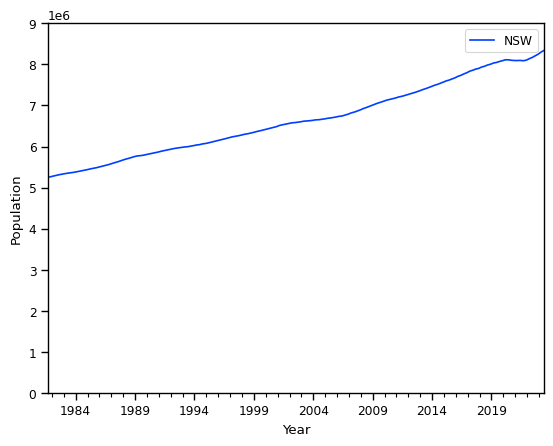

In [45]:
population['date'] = pd.to_datetime(dict(year=population.year, month=population.month, day=1))

pop = population[['state', 'date', 'population']]
pop.set_index("date", inplace=True)
pop.groupby("state")["population"].plot(legend=True, xlabel="Year", ylabel="Population", ylim =(0, 9000000))



#### Generate data profile report (*using ydata_profiler*)

In [46]:
display(population.dtypes)

year                   int64
month                  int32
state                 object
population             int64
date          datetime64[ns]
dtype: object

In [47]:
profile_nsw_pop = ProfileReport(pop, title="Population NSW Data Profile")

#### Output data profile report to widgets

In [48]:
#profile_nsw_pop.to_widgets()
profile_nsw_pop

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data preparation and EDA of GSP (*Gross State Product*) dataset

#### Set variables

In [49]:
fpath = "..\\data\\all_raw_files"
fname_aus_gsp = "GDP_Annual_Gross_State_Product_All_States.xlsx"
colnames = ['date', 'nsw_cvm', 'vic_cvm', 'qld_cvm', 'sa_cvm', 'wa_cvm', 'tas_cvm', 'nt_cvm', 'act_cvm', 'aus_cvm']

#### Read raw data file

In [50]:
df_aus_gsp = pd.read_excel(f'{fpath}\{fname_aus_gsp}', sheet_name="Data1", skiprows=9, usecols="A:J", names=colnames)

#### Data preparation

In [51]:
df_aus_gsp['month'] = df_aus_gsp['date'].dt.month
df_aus_gsp['year'] = df_aus_gsp['date'].dt.year
df_aus_gsp

date  nsw_cvm  vic_cvm  qld_cvm  sa_cvm  wa_cvm  tas_cvm  nt_cvm   
0  1990-06-01   335735   216165   141394   62973  113786    17721   11319  \
1  1991-06-01   337278   210558   141579   62741  114505    17702   11607   
2  1992-06-01   337926   207543   146454   61664  118247    18138   11298   
3  1993-06-01   347414   217875   155635   63323  123722    18726   11314   
4  1994-06-01   360245   225250   163389   65059  132148    19124   11116   
5  1995-06-01   373474   232307   172822   65967  139504    19616   11655   
6  1996-06-01   387865   240327   178624   68639  147706    20368   12585   
7  1997-06-01   400572   250923   188157   71249  152776    20714   12849   
8  1998-06-01   415409   265717   195747   75166  161351    21489   13720   
9  1999-06-01   435452   282577   207327   76736  166252    21981   15284   
10 2000-06-01   454551   292216   216949   79433  173079    22107   15117   
11 2001-06-01   462443   297726   223422   81859  174727    21921   15727   
12 2002-06-01   471052   309125   237637   85909  186351    23077   17042   
13 2003-06-01   480849   317744   248524   88107  195996    23727   17235   
14 2004-06-01   494126   329621   265133   91029  210295    24945   17367   
15 2005-06-01   500740   343515   279279   92929  218121    25593   18162   
16 2006-06-01   506876   351392   293682   94203  228867    26614   19356   
17 2007-06-01   515768   361288   313527   95914  244161    27324   21750   
18 2008-06-01   526459   374193   328402  100398  256777    28480   21977   
19 2009-06-01   534051   381400   332831  103137  262862    29285   23843   
20 2010-06-01   542558   385336   339914  105358  278607    29543   23732   
21 2011-06-01   553440   396253   342795  107659  291562    30250   24414   
22 2012-06-01   566882   405822   362790  108761  315714    30849   25391   
23 2013-06-01   579398   409802   373159  109578  334784    30685   27120   
24 2014-06-01   593009   418902   380604  110004  354070    31155   27450   
25 2015-06-01   609333   430757   383818  111249  362109    31515   27816   
26 2016-06-01   631961   445714   392991  111865  365881    32085   28367   
27 2017-06-01   648206   462737   403260  114015  362200    32473   28782   
28 2018-06-01   662829   478591   419368  116570  370153    33667   29356   
29 2019-06-01   680189   493087   423285  117925  376299    34897   29020   
30 2020-06-01   673316   491651   418498  116749  380717    34931   30758   
31 2021-06-01   688693   490667   430157  122455  393223    36598   30253   
32 2022-06-01   706732   521709   454026  129272  404762    38171   31792   
33 2023-06-01   733087   535489   464580  134209  418775    38584   30123   

    act_cvm  aus_cvm  month  year  
0     15577   925958      6  1990  
1     15960   922422      6  1991  
2     16026   926367      6  1992  
3     16639   963840      6  1993  
4     17377  1002198      6  1994  
5     18027  1041115      6  1995  
6     18049  1081343      6  1996  
7     18797  1123658      6  1997  
8     19548  1176057      6  1998  
9     20692  1235185      6  1999  
10    21222  1283623      6  2000  
11    22320  1309618      6  2001  
12    23092  1361736      6  2002  
13    24136  1403823      6  2003  
14    24855  1463125      6  2004  
15    25665  1509274      6  2005  
16    26309  1550859      6  2006  
17    27893  1609379      6  2007  
18    29174  1667095      6  2008  
19    29966  1698646      6  2009  
20    31273  1736467      6  2010  
21    32182  1778298      6  2011  
22    33542  1847979      6  2012  
23    34647  1896141      6  2013  
24    34727  1945581      6  2014  
25    35714  1988419      6  2015  
26    37400  2043680      6  2016  
27    38912  2091067      6  2017  
28    40505  2151841      6  2018  
29    42197  2198775      6  2019  
30    43759  2191416      6  2020  
31    45467  2237695      6  2021  
32    46757  2333221      6  2022  
33    48767  2403614      6  2023

#### Generate data profile report (*using ydata_profiler*)

In [52]:
profile_aus_gsp = ProfileReport(df_aus_gsp, title="GSP Data Profile")

#### Output data profile report to widgets

In [53]:
#profile_aus_gsp.to_widgets()
profile_aus_gsp

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Get NSW data and add month, year and interpolate annual gdp to monthly using formula: monthly gdp = annual gdp / 12

In [54]:
# New dataframe with a monthly gdp = current value/12 (add 12 months)
value_arr = []
month_arr = []
year_arr = []

for x in range(len(df_aus_gsp)):
    value = df_aus_gsp.iloc[x,1]
    month = df_aus_gsp.iloc[x,10]
    year = df_aus_gsp.iloc[x,11]
    
    for x in range(12):
        month_to_use = (month + x) %  12
        month_to_use = 12 if month_to_use ==0 else month_to_use
        year_to_use = year if (month+x)<13 else year+1
        
        value_arr.append(value/12)
        month_arr.append(month_to_use)
        year_arr.append(year_to_use)

        
data = {'year' : year_arr, 'month' : month_arr, 'gsp' : value_arr}
df_gsp = pd.DataFrame(data)
df_gsp.head(20)

year  month           gsp
0   1990      6  27977.916667
1   1990      7  27977.916667
2   1990      8  27977.916667
3   1990      9  27977.916667
4   1990     10  27977.916667
5   1990     11  27977.916667
6   1990     12  27977.916667
7   1991      1  27977.916667
8   1991      2  27977.916667
9   1991      3  27977.916667
10  1991      4  27977.916667
11  1991      5  27977.916667
12  1991      6  28106.500000
13  1991      7  28106.500000
14  1991      8  28106.500000
15  1991      9  28106.500000
16  1991     10  28106.500000
17  1991     11  28106.500000
18  1991     12  28106.500000
19  1992      1  28106.500000

## Prepare multi-variable dataframe for NSW by merging datasets

#### Merge Total Demand and Temperature

In [55]:
df_nsw_temp

LOCATION         DATETIME  TEMPERATURE
0       Bankstown    1/1/2010 0:00         23.1
1       Bankstown    1/1/2010 0:01         23.1
2       Bankstown    1/1/2010 0:30         22.9
3       Bankstown    1/1/2010 0:50         22.7
4       Bankstown    1/1/2010 1:00         22.6
...           ...              ...          ...
220321  Bankstown  17/3/2021 23:00         19.1
220322  Bankstown  17/3/2021 23:20         19.0
220323  Bankstown  17/3/2021 23:30         18.8
220324  Bankstown  17/3/2021 23:34         18.8
220325  Bankstown   18/3/2021 0:00         18.6

[220326 rows x 3 columns]

In [56]:
main_df = pd.merge(df_nsw_temp, df_nsw_tdemand, on = 'DATETIME', how='outer')

#### EDA of Temperature and Total Demand for different intervals

In [57]:
main_df.describe()

TEMPERATURE    TOTALDEMAND
count  220326.000000  196526.000000
mean       17.418827    8113.119994
std         5.849763    1299.510032
min        -1.300000    5074.630000
25%        13.400000    7150.060000
50%        17.700000    8053.215000
75%        21.300000    8958.550000
max        44.700000   14579.860000

In [58]:
main_df = pd.merge(df_nsw_temp, df_nsw_tdemand, on = 'DATETIME')

In [59]:
main_df.describe()

TEMPERATURE    TOTALDEMAND
count  195947.000000  195947.000000
mean       17.530995    8111.924589
std         5.884212    1299.171401
min        -1.300000    5074.630000
25%        13.500000    7149.430000
50%        17.900000    8052.180000
75%        21.500000    8956.985000
max        44.700000   14579.860000

In [60]:
main_df.head()

LOCATION       DATETIME  TEMPERATURE  TOTALDEMAND REGIONID
0  Bankstown  1/1/2010 0:00         23.1      8038.00     NSW1
1  Bankstown  1/1/2010 0:30         22.9      7809.31     NSW1
2  Bankstown  1/1/2010 1:00         22.6      7483.69     NSW1
3  Bankstown  1/1/2010 1:30         22.5      7117.23     NSW1
4  Bankstown  1/1/2010 2:00         22.5      6812.03     NSW1

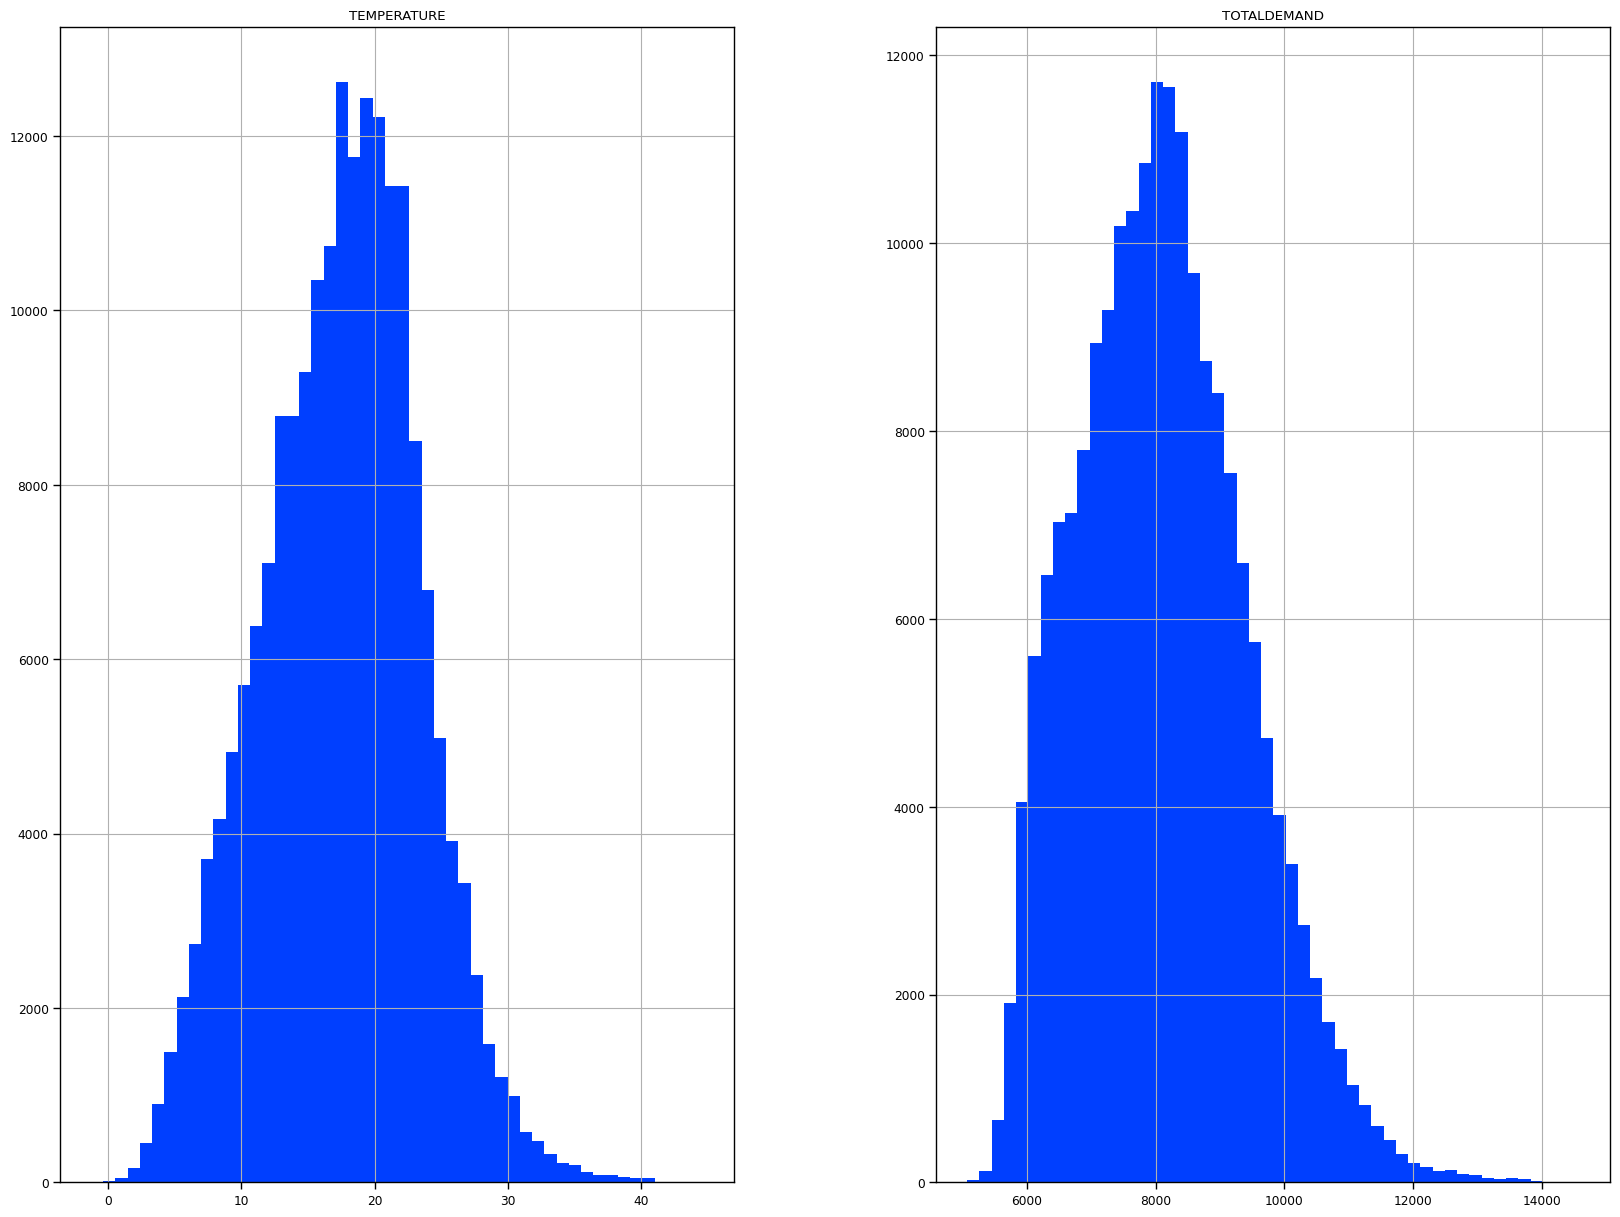

In [61]:
main_df.hist(bins=50, figsize=(20, 15))
plt.show()

C:\Users\JohnD'Souza\AppData\Local\Temp\ipykernel_7416\3619322934.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=main_df, x="TEMPERATURE", y="TOTALDEMAND",  palette="pastel")


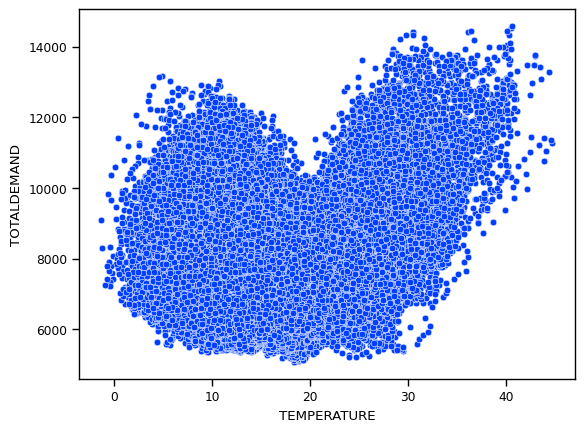

In [62]:
#sns.color_palette("Set2")
sns.scatterplot(data=main_df, x="TEMPERATURE", y="TOTALDEMAND",  palette="pastel")
#sns.color_palette("Set2")
plt.show()

In [63]:
main_df = main_df.dropna(how='all').dropna(how='all', axis=1)

In [64]:
main_df['DATETIME'] = pd.to_datetime(main_df['DATETIME'], format='mixed')

In [65]:
main_df.iloc[574,]

LOCATION                 Bankstown
DATETIME       2010-01-13 00:00:00
TEMPERATURE                   27.1
TOTALDEMAND                8915.77
REGIONID                      NSW1
Name: 574, dtype: object

In [66]:
main_df['day'] = main_df['DATETIME'].dt.day
main_df['month'] = main_df['DATETIME'].dt.month
main_df['year'] = main_df['DATETIME'].dt.year
main_df['hour'] = main_df['DATETIME'].dt.hour
main_df['date'] = main_df['DATETIME'].dt.date
main_df['weekday'] = main_df['DATETIME'].dt.weekday
main_df['day_name'] = main_df['DATETIME'].dt.day_name()

In [67]:
main_df

LOCATION            DATETIME  TEMPERATURE  TOTALDEMAND REGIONID  day   
0       Bankstown 2010-01-01 00:00:00         23.1      8038.00     NSW1    1  \
1       Bankstown 2010-01-01 00:30:00         22.9      7809.31     NSW1    1   
2       Bankstown 2010-01-01 01:00:00         22.6      7483.69     NSW1    1   
3       Bankstown 2010-01-01 01:30:00         22.5      7117.23     NSW1    1   
4       Bankstown 2010-01-01 02:00:00         22.5      6812.03     NSW1    1   
...           ...                 ...          ...          ...      ...  ...   
195942  Bankstown 2021-03-17 22:00:00         19.7      7419.77     NSW1   17   
195943  Bankstown 2021-03-17 22:30:00         19.5      7417.91     NSW1   17   
195944  Bankstown 2021-03-17 23:00:00         19.1      7287.32     NSW1   17   
195945  Bankstown 2021-03-17 23:30:00         18.8      7172.39     NSW1   17   
195946  Bankstown 2021-03-18 00:00:00         18.6      7094.51     NSW1   18   

        month  year  hour        date  weekday   day_name  
0           1  2010     0  2010-01-01        4     Friday  
1           1  2010     0  2010-01-01        4     Friday  
2           1  2010     1  2010-01-01        4     Friday  
3           1  2010     1  2010-01-01        4     Friday  
4           1  2010     2  2010-01-01        4     Friday  
...       ...   ...   ...         ...      ...        ...  
195942      3  2021    22  2021-03-17        2  Wednesday  
195943      3  2021    22  2021-03-17        2  Wednesday  
195944      3  2021    23  2021-03-17        2  Wednesday  
195945      3  2021    23  2021-03-17        2  Wednesday  
195946      3  2021     0  2021-03-18        3   Thursday  

[195947 rows x 12 columns]

In [68]:
main_df.groupby('date')[["TEMPERATURE", "TOTALDEMAND"]].mean()

TEMPERATURE  TOTALDEMAND
date                                
2010-01-01    25.185417  7801.352917
2010-01-02    24.461702  9557.546383
2010-01-03    18.737500  8560.798958
2010-01-04    19.191489  8499.952553
2010-01-05    15.912821  8025.070256
...                 ...          ...
2021-11-02    21.970833  7562.555417
2021-11-03    22.175000  7841.899792
2021-12-01    23.850000  8058.727083
2021-12-02    24.556250  8055.056250
2021-12-03    22.650000  7846.094375

[4092 rows x 2 columns]

<Axes: xlabel='DATETIME'>

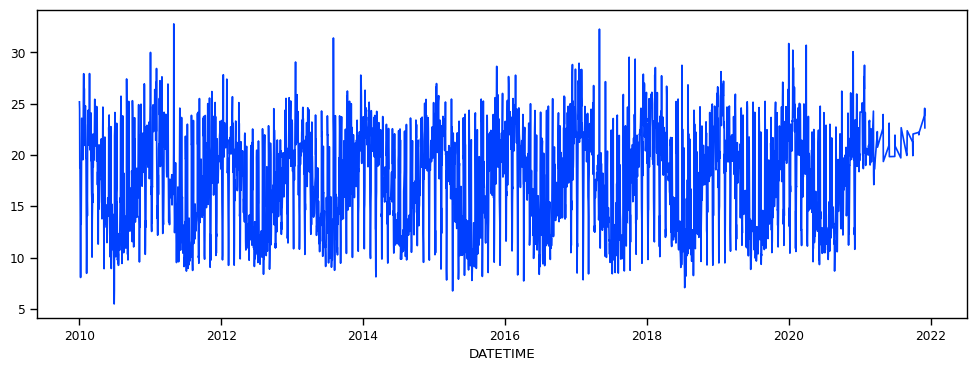

In [69]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.date])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

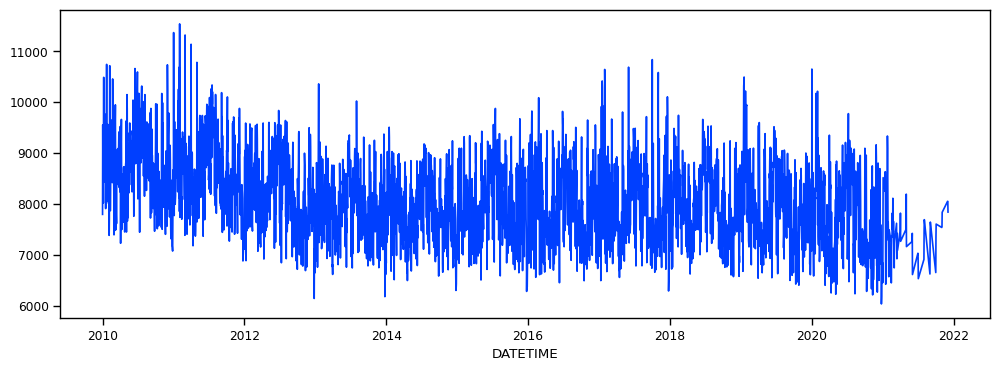

In [70]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.date])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

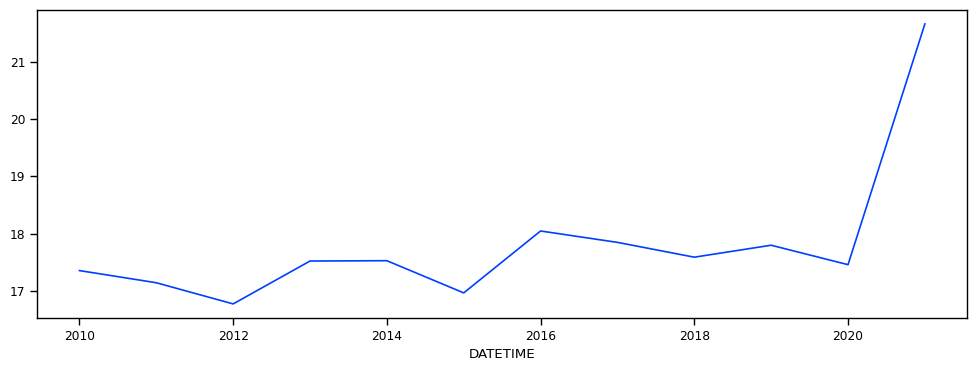

In [71]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.year])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

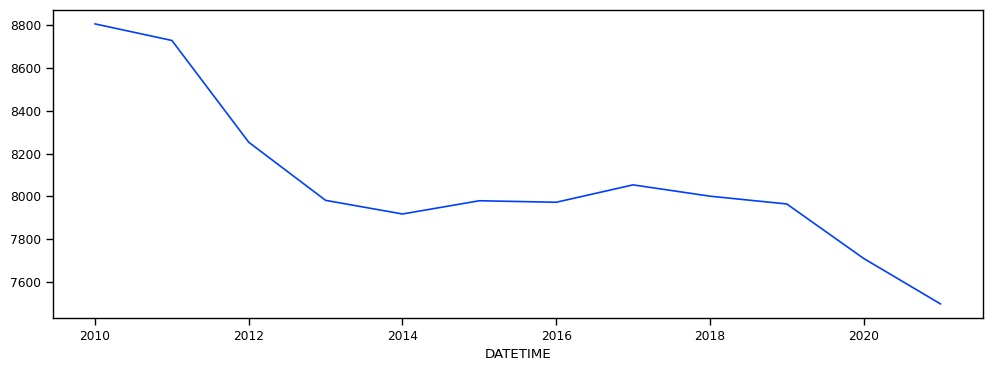

In [72]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.year])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

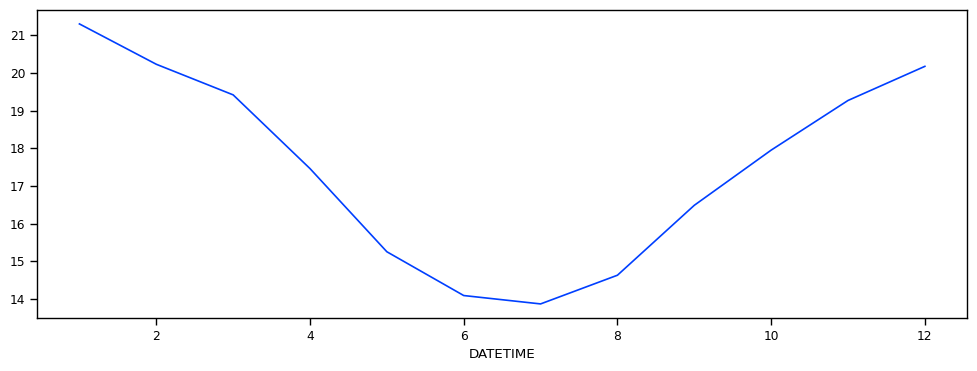

In [73]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.month])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

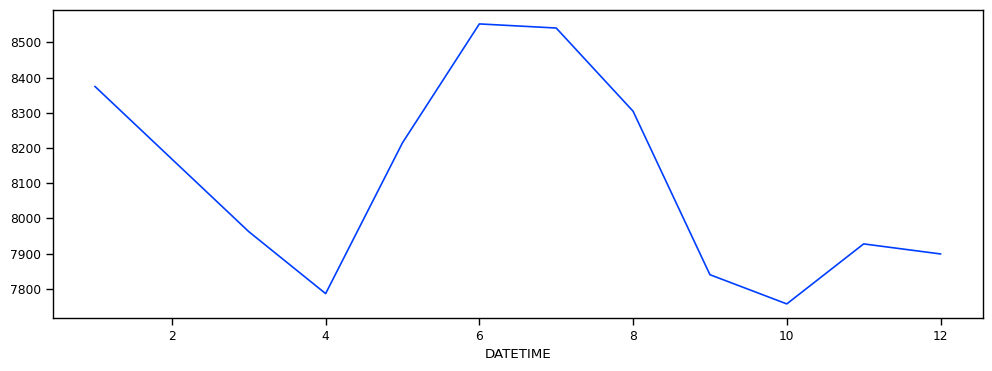

In [74]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.month])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<Axes: xlabel='DATETIME'>

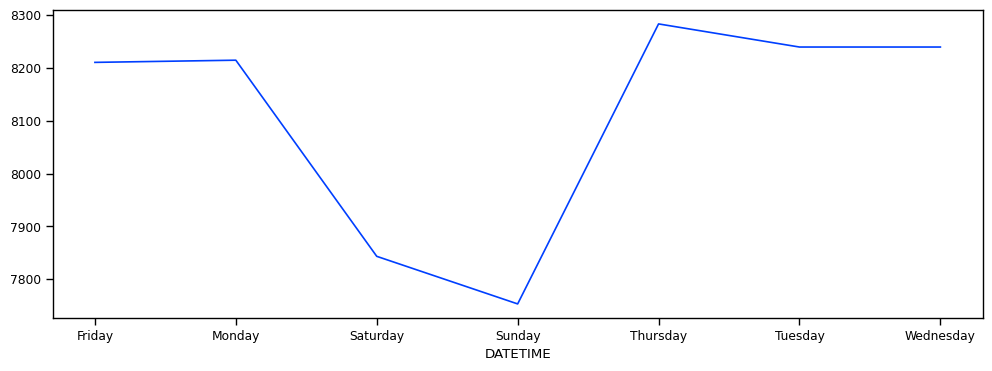

In [75]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.day_name()])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

In [76]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].mean()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010        17.350959  8806.634881
2011        17.137916  8729.258601
2012        16.767150  8253.115030
2013        17.518075  7981.460353
2014        17.524010  7917.697750
2015        16.960325  7979.624178
2016        18.044215  7972.542419
2017        17.844709  8053.839384
2018        17.585447  8001.012442
2019        17.794789  7964.534511
2020        17.454181  7709.863122
2021        21.669910  7497.118816

In [77]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].median()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010             17.4     8924.210
2011             17.1     8810.075
2012             17.3     8317.960
2013             17.7     8044.295
2014             18.1     7984.690
2015             17.3     7990.315
2016             18.3     7933.990
2017             18.3     7960.675
2018             18.0     7947.570
2019             18.2     7814.980
2020             17.6     7522.500
2021             21.2     7444.600

In [78]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010            17259        17259
2011            17502        17502
2012            17534        17534
2013            17516        17516
2014            17518        17518
2015            17520        17520
2016            17347        17347
2017            17520        17520
2018            17495        17495
2019            17520        17520
2020            17567        17567
2021             3649         3649

In [79]:
main_df.groupby([main_df["DATETIME"].dt.month])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
1               17410        17410
2               15810        15810
3               16707        16707
4               15940        15940
5               16457        16457
6               15939        15939
7               16305        16305
8               16492        16492
9               15974        15974
10              16474        16474
11              15952        15952
12              16487        16487

In [80]:
main_df.groupby([main_df["DATETIME"].dt.day])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
1                6915         6915
2                6903         6903
3                6863         6863
4                6324         6324
5                6297         6297
6                6335         6335
7                6326         6326
8                6325         6325
9                6324         6324
10               6338         6338
11               6336         6336
12               6336         6336
13               6473         6473
14               6471         6471
15               6456         6456
16               6417         6417
17               6402         6402
18               6375         6375
19               6400         6400
20               6401         6401
21               6388         6388
22               6418         6418
23               6420         6420
24               6424         6424
25               6425         6425
26               6421         6421
27               6425         6425
28               6430         6430
29               5993         5993
30               5842         5842
31               3744         3744

#### Aggregate monthly information

In [81]:
main_df.columns

Index(['LOCATION', 'DATETIME', 'TEMPERATURE', 'TOTALDEMAND', 'REGIONID', 'day',
       'month', 'year', 'hour', 'date', 'weekday', 'day_name'],
      dtype='object')

In [82]:
result = main_df.groupby(['year','month']).agg({'TEMPERATURE': ['mean', 'min', 'max']
                                                , 'TOTALDEMAND' : ['mean', 'sum', 'max']}).droplevel(0, axis=1).reset_index()

result.columns=['year', 'month', "temp_mean" ,"temp_min","temp_max", "demand_mean", "total_consumption", "demand_max"]
result["total_consumption"] = result["total_consumption"]/2

In [83]:
result.columns

Index(['year', 'month', 'temp_mean', 'temp_min', 'temp_max', 'demand_mean',
       'total_consumption', 'demand_max'],
      dtype='object')

#### Add the average max/min demand and temperature values ( the average of the daily maximums/minimums for a month)

In [84]:
# Calculate minimum and maximum daily temperature and maximum daily demand; then find the average monthly value of these metrics.
result1 = main_df.groupby(['year','month', 'day']).agg({'TEMPERATURE': ['min', 'max']
                                                        ,'TOTALDEMAND' : ['max']}).groupby(['year','month']).mean().droplevel(0, axis=1).reset_index()

# Rename columns
result1.columns=['year', 'month', 'temp_avg_daily_min', 'temp_avg_daily_max', 'demand_avg_daily_max']

# Add average daily minimum temperature, average daily maximum temperature and average daily maximum demand to the final dataframe
result = result.merge(result1, on= ['year', 'month'], how='left')

In [85]:
result.columns

Index(['year', 'month', 'temp_mean', 'temp_min', 'temp_max', 'demand_mean',
       'total_consumption', 'demand_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'demand_avg_daily_max'],
      dtype='object')

#### Add the Degree Days (Degree Day = abs(Average Daily Temperature - 18 deg C))

In [86]:
# Calculate mean daily temperature
result2 = main_df.groupby(['year','month', 'day'])['TEMPERATURE'].mean().reset_index()

# Calculate 'degree days'
result2['degree_days'] = (result2['TEMPERATURE'] - 18).abs()

# Remove columns that are not needed
result2.drop(['TEMPERATURE', 'day'], axis=1, inplace=True)

# Calculate monthly 'degree days' 
result3 = result2.groupby(['year','month']).sum().reset_index()

# Add 'degree days' to final dataframe
result = result.merge(result3, on= ['year', 'month'], how='left')

result

year  month  temp_mean  temp_min  temp_max  demand_mean   
0    2010      1  20.868008       1.6      41.1  8941.450389  \
1    2010      2  20.218907       3.2      35.4  8855.467677   
2    2010      3  19.828286       6.3      34.7  8698.725127   
3    2010      4  17.593856       6.5      29.9  8452.863411   
4    2010      5  15.323485       3.1      28.4  8897.770510   
..    ...    ...        ...       ...       ...          ...   
139  2021      8  21.104167      16.9      30.7  7368.353056   
140  2021      9  20.999306      14.2      27.5  7229.393819   
141  2021     10  21.084722      14.8      26.9  7209.823194   
142  2021     11  22.118056      15.7      27.3  7649.492569   
143  2021     12  23.685417      16.1      33.5  7986.625903   

     total_consumption  demand_max  temp_avg_daily_min  temp_avg_daily_max   
0          6554083.135    13765.04           16.380645           25.858065  \
1          5831325.465    13377.27           16.146429           24.682143   
2          6319623.805    11991.47           15.496774           24.725806   
3          5984627.295    11436.13           12.780000           23.063333   
4          6459781.390    12386.49           11.187097           19.596774   
..                 ...         ...                 ...                 ...   
139         530521.420     9043.62           17.766667           24.966667   
140         520516.355     9206.19           15.433333           25.300000   
141         519107.270     8841.21           16.300000           25.466667   
142         550763.465     9573.70           16.466667           26.566667   
143         575037.065    10376.04           18.100000           30.200000   

     demand_avg_daily_max  degree_days  
0            10613.530000   144.511358  
1            10380.667857   124.982743  
2            10132.978710   106.809763  
3             9804.072333    68.136038  
4            10558.023548   123.937772  
..                    ...          ...  
139           8410.176667     9.312500  
140           8469.680000     8.997917  
141           8575.093333     9.254167  
142           9336.970000    12.354167  
143           9784.833333    17.056250  

[144 rows x 12 columns]

In [87]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  144 non-null    int32  
 1   month                 144 non-null    int32  
 2   temp_mean             144 non-null    float64
 3   temp_min              144 non-null    float64
 4   temp_max              144 non-null    float64
 5   demand_mean           144 non-null    float64
 6   total_consumption     144 non-null    float64
 7   demand_max            144 non-null    float64
 8   temp_avg_daily_min    144 non-null    float64
 9   temp_avg_daily_max    144 non-null    float64
 10  demand_avg_daily_max  144 non-null    float64
 11  degree_days           144 non-null    float64
dtypes: float64(10), int32(2)
memory usage: 12.5 KB


#### Merge Solar PV dataset into the dataframe

In [88]:
pv_import = pv[['month','year','pv_capacity']].reset_index(drop=True)
pv_import['month'] = pv_import['month'].astype(int)

result = result.merge(pv_import, on= ['year', 'month'], how='left')

In [89]:
result.columns

Index(['year', 'month', 'temp_mean', 'temp_min', 'temp_max', 'demand_mean',
       'total_consumption', 'demand_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'demand_avg_daily_max', 'degree_days',
       'pv_capacity'],
      dtype='object')

#### Merge Population dataset into the dataframe

In [90]:
population

year  month state  population       date
0    1981      9   NSW     5249455 1981-09-01
1    1981     10   NSW     5255268 1981-10-01
2    1981     11   NSW     5261081 1981-11-01
3    1981     12   NSW     5266894 1981-12-01
4    1982      1   NSW     5273302 1982-01-01
..    ...    ...   ...         ...        ...
497  2023      2   NSW     8280704 2023-02-01
498  2023      3   NSW     8298017 2023-03-01
499  2023      4   NSW     8311793 2023-04-01
500  2023      5   NSW     8325570 2023-05-01
501  2023      6   NSW     8339347 2023-06-01

[502 rows x 5 columns]

In [91]:
result = result.merge(population, on= ['year', 'month'], how='left')
result = result.drop('state', axis=1)

In [92]:
result.columns

Index(['year', 'month', 'temp_mean', 'temp_min', 'temp_max', 'demand_mean',
       'total_consumption', 'demand_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'demand_avg_daily_max', 'degree_days',
       'pv_capacity', 'population', 'date'],
      dtype='object')

#### Merge GSP dataset into the dataframe 

In [93]:
df_gsp.columns

Index(['year', 'month', 'gsp'], dtype='object')

In [94]:
result = result.merge(df_gsp, on= ['year', 'month'], how='left')

In [95]:
result.columns

Index(['year', 'month', 'temp_mean', 'temp_min', 'temp_max', 'demand_mean',
       'total_consumption', 'demand_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'demand_avg_daily_max', 'degree_days',
       'pv_capacity', 'population', 'date', 'gsp'],
      dtype='object')

#### Finalise multi-variable dataframe for NSW

In [96]:
#result =  result.drop('date', axis=1)
new_column_order = ['year', 'month', 'date', 'temp_mean', 'temp_min', 'temp_max', 'temp_avg_daily_min', 'temp_avg_daily_max', 'degree_days', 'demand_mean', 'demand_max', 'demand_avg_daily_max', 'total_consumption', 'pv_capacity', 'population', 'gsp']
result = result[new_column_order]

In [97]:
result

year  month       date  temp_mean  temp_min  temp_max   
0    2010      1 2010-01-01  20.868008       1.6      41.1  \
1    2010      2 2010-02-01  20.218907       3.2      35.4   
2    2010      3 2010-03-01  19.828286       6.3      34.7   
3    2010      4 2010-04-01  17.593856       6.5      29.9   
4    2010      5 2010-05-01  15.323485       3.1      28.4   
..    ...    ...        ...        ...       ...       ...   
139  2021      8 2021-08-01  21.104167      16.9      30.7   
140  2021      9 2021-09-01  20.999306      14.2      27.5   
141  2021     10 2021-10-01  21.084722      14.8      26.9   
142  2021     11 2021-11-01  22.118056      15.7      27.3   
143  2021     12 2021-12-01  23.685417      16.1      33.5   

     temp_avg_daily_min  temp_avg_daily_max  degree_days  demand_mean   
0             16.380645           25.858065   144.511358  8941.450389  \
1             16.146429           24.682143   124.982743  8855.467677   
2             15.496774           24.725806   106.809763  8698.725127   
3             12.780000           23.063333    68.136038  8452.863411   
4             11.187097           19.596774   123.937772  8897.770510   
..                  ...                 ...          ...          ...   
139           17.766667           24.966667     9.312500  7368.353056   
140           15.433333           25.300000     8.997917  7229.393819   
141           16.300000           25.466667     9.254167  7209.823194   
142           16.466667           26.566667    12.354167  7649.492569   
143           18.100000           30.200000    17.056250  7986.625903   

     demand_max  demand_avg_daily_max  total_consumption  pv_capacity   
0      13765.04          10613.530000        6554083.135    28278.392  \
1      13377.27          10380.667857        5831325.465    32153.986   
2      11991.47          10132.978710        6319623.805    38195.588   
3      11436.13           9804.072333        5984627.295    45142.723   
4      12386.49          10558.023548        6459781.390    54370.332   
..          ...                   ...                ...          ...   
139     9043.62           8410.176667         530521.420  3954209.744   
140     9206.19           8469.680000         520516.355  4033918.477   
141     8841.21           8575.093333         519107.270  4112353.036   
142     9573.70           9336.970000         550763.465  4192992.282   
143    10376.04           9784.833333         575037.065  4291459.770   

     population           gsp  
0       7110454  44504.250000  
1       7119405  44504.250000  
2       7128356  44504.250000  
3       7133668  44504.250000  
4       7138980  44504.250000  
..          ...           ...  
139     8091356  57391.083333  
140     8088503  57391.083333  
141     8092743  57391.083333  
142     8096983  57391.083333  
143     8101223  57391.083333  

[144 rows x 16 columns]

#### Write multi-variable dataframe for NSW to file

In [98]:
fpath = "..\\data\\all_raw_files"
fname_output = 'model_data.csv'
result.to_csv(f'{fpath}\{fname_output}', index=False)

## **Time Series Models**

#### Set python variables

In [99]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2010 to 2020
start_mth = datetime.datetime(2010, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read pre-processed multi-variable dataset into pandas dataframe

In [100]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

#### Prepare data for time series modelling

In [101]:
# Convert date column to datetime datatype
df_model_data['date'] = pd.to_datetime(df_model_data['date'])

# Set dataframe index to date column
df_model_data.index = df_model_data.date

# Filter records within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

# Set the forecast window to 24 months
forecast_mths = 24 

#### Prepare data for SARIMA and Holt-Winter

In [102]:
# Create test and train subsets, where test holds all rows for the last 24 months
train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train_adm = train['demand_avg_daily_max']
y_test_adm = test['demand_avg_daily_max']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))

Train size: 108 , Test size: 24


#### Plot Seasonality and Trend in Timeseries for Average Daily Maximum Demand

In [103]:
pivot_df = df_model_data.pivot_table(index='month', columns='year', values='demand_avg_daily_max')

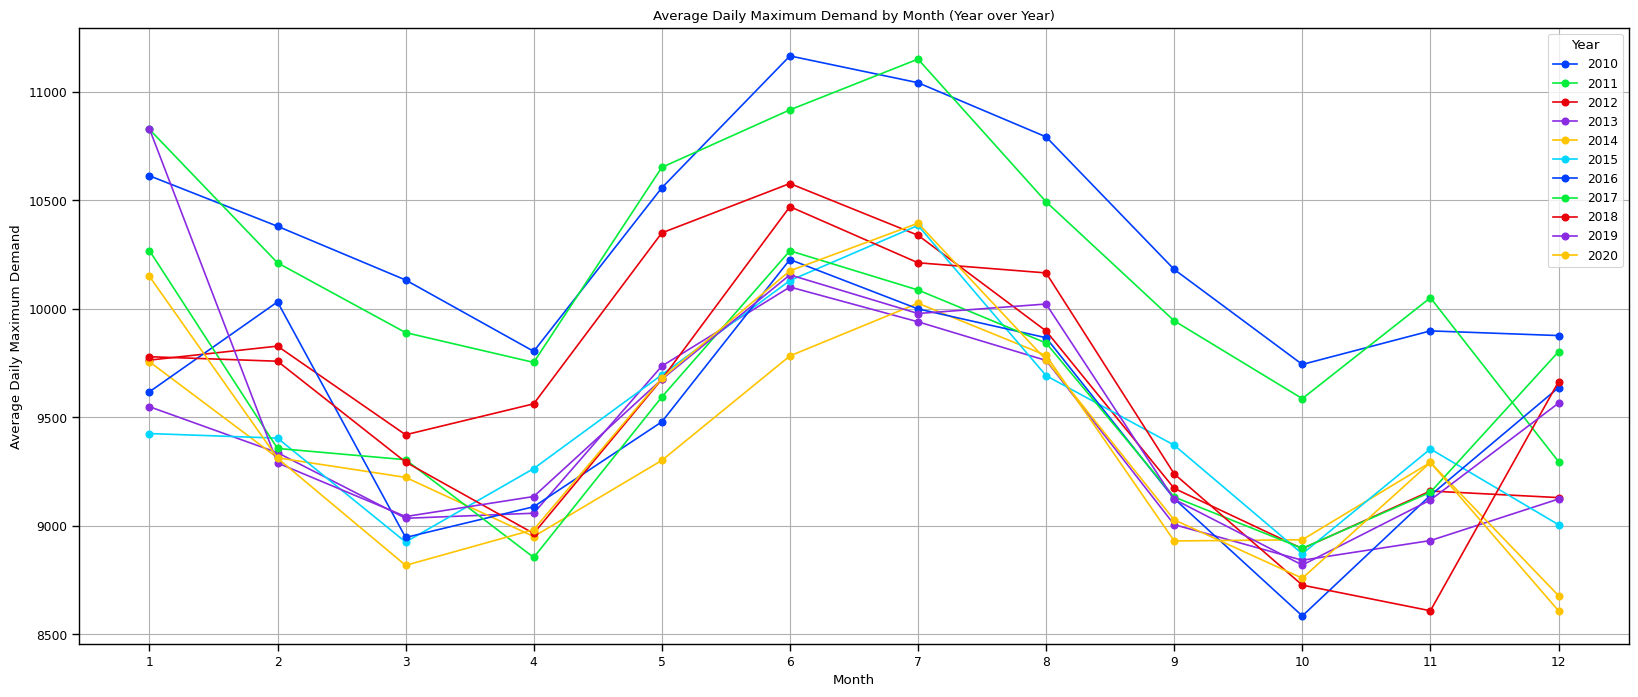

In [104]:
# Plot the line chart
pivot_df.plot(kind='line', marker='o', figsize=(20, 8))
plt.title('Average Daily Maximum Demand by Month (Year over Year)')
plt.xlabel('Month')
plt.ylabel('Average Daily Maximum Demand')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.legend(title='Year', loc='best')
plt.show()

In [105]:
print(df_model_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2010-01-01 to 2020-12-01
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  132 non-null    int64         
 1   month                 132 non-null    int64         
 2   date                  132 non-null    datetime64[ns]
 3   temp_mean             132 non-null    float64       
 4   temp_min              132 non-null    float64       
 5   temp_max              132 non-null    float64       
 6   temp_avg_daily_min    132 non-null    float64       
 7   temp_avg_daily_max    132 non-null    float64       
 8   degree_days           132 non-null    float64       
 9   demand_mean           132 non-null    float64       
 10  demand_max            132 non-null    float64       
 11  demand_avg_daily_max  132 non-null    float64       
 12  total_consumption     132 non-null    float64       
 13  p

#### Perform Augmented Dicky-Fuller (ADF) Test for Stationarity of Timeseries data Average Daily Maximum Demand

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.622951
p-value                          0.088346
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The series is NOT stationary


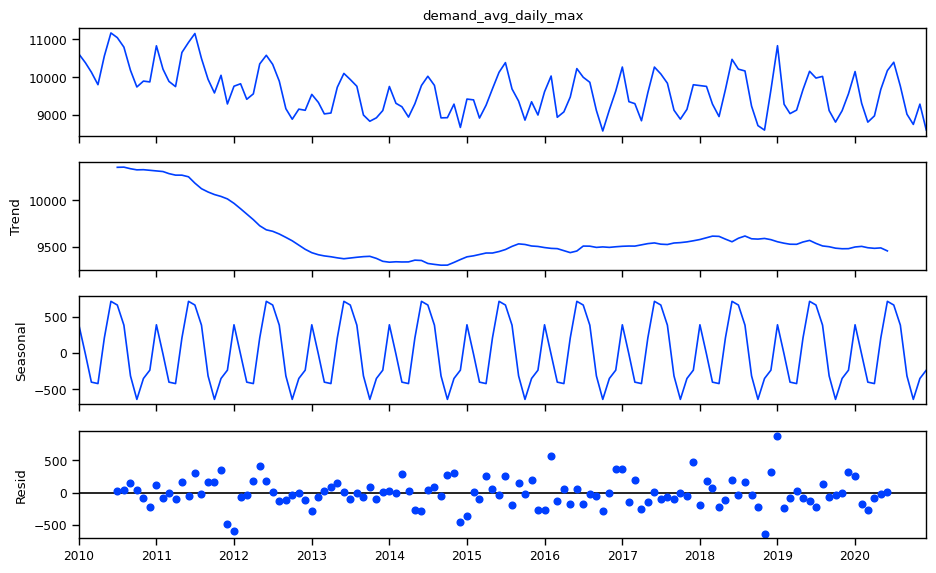

In [106]:
# Apply Augmented Dickey-Fuller test for Average Daily Maximum Demand
dickey_fuller_test(df_model_data.demand_avg_daily_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_avg_daily_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

## Model 1 - Seasonal Auto-Regresive Integrated Moving Average (SARIMA)

#### Run SARIMA forecast for *Average Daily Maximum Demand*

In [107]:
# SARIMA model run
y_train = y_train_adm
y_test = y_test_adm

sr_pred = sarimax(train_data=y_train, test_data=y_test, freq=12)

Performing stepwise search to minimize aic


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1557.773, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1633.018, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1560.892, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1591.314, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1631.053, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1590.868, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1568.692, Time=0.54 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1557.943, Time=2.29 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1585.110, Time=0.74 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1566.185, Time=1.06 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1546.989, Time=1.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1591.868, Time=0.47 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1548.101, Time=3.51 sec
 ARIM

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:               demand_avg_daily_max   No. Observations:                  108
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -757.755
Date:                            Sun, 21 Apr 2024   AIC                           1529.509
Time:                                    21:16:35   BIC                           1548.219
Sample:                                01-01-2010   HQIC                          1537.094
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1936      0.180      1.077      0.282      -0.159       0.546
ar.L2         -0.0518      0.108   

#### Review results of SARIMA forecasts for *Average Daily Maximum Demand*

SARIMA
Mean Absolute Percentage Error (MAPE) : 2.48%
Root Mean Square Error : 336.9956802350909


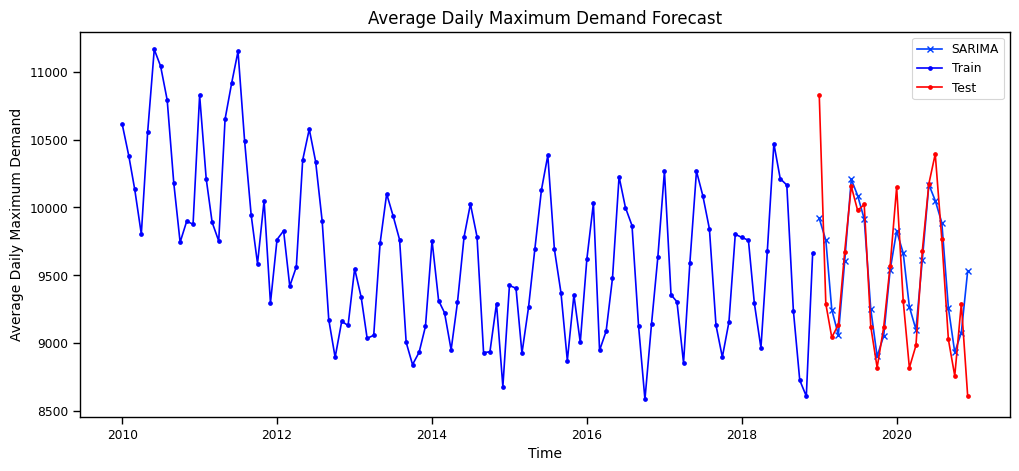

In [108]:
models = {
    #'Holt Winter': hw_pred,
    'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

## Model 2 - Holt-Winter Exponential Smoothing

#### Run Holt-Winter Exponential Smoothing forecast for *Average Daily Maximum Demand*

In [109]:
# Holt-Winter Forecast
hw_pred = holt_winter(train_data=y_train, test_data=y_test, seasonal_periods=12, trend='mul', seasonal='mul')

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:     demand_avg_daily_max   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                        6037835.084
Optimized:                         True   AIC                           1212.594
Trend:                   Multiplicative   BIC                           1255.508
Seasonal:                Multiplicative   AICC                          1220.279
Seasonal Periods:                    12   Date:                 Sun, 21 Apr 2024
Box-Cox:                          False   Time:                         21:16:37
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2525000                alpha                 True
smoothing_trend          

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Review results of Holt Winter forecasts for *Average Daily Maximum Demand*

Holt Winter
Mean Absolute Percentage Error (MAPE) : 1.93%
Root Mean Square Error : 306.2832932592546


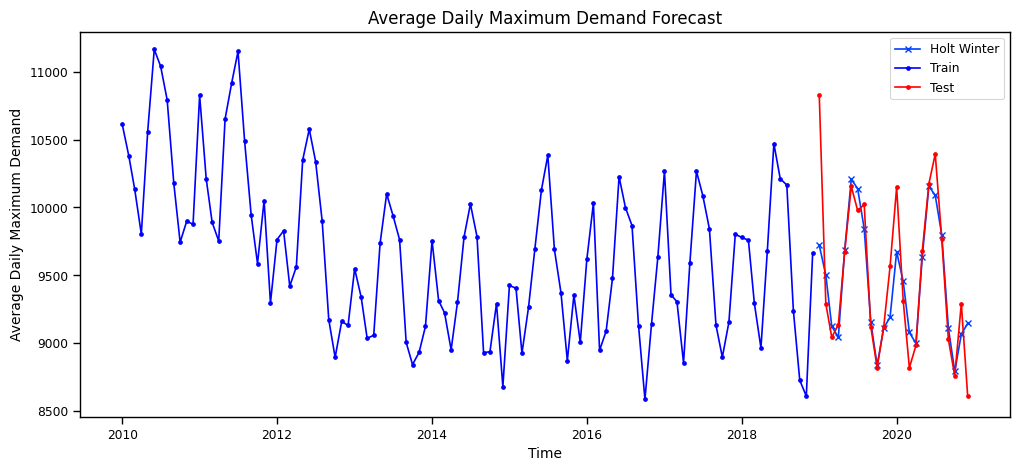

In [110]:
models = {
    'Holt Winter': hw_pred
    #,'SARIMA': sr_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

## Model 3 - Prophet

#### Prepare data for Prophet

In [111]:
# Set the forecast window to 24 months
forecast_mths = 24 

# Reduce dataframe to only include date and demand variables
df_model_reduced = df_model_data[['date', 'demand_avg_daily_max']]

# Change column names to those expected by Prophet
df_model_reduced.columns = ['ds', 'y']

# Create test and train subsets, where test holds all rows for the last 24 months
train = df_model_reduced[ : -forecast_mths]
test = df_model_reduced[-forecast_mths :]

y_train_prophet = train[['ds', 'y']]
y_test_prophet = DataFrame(test['ds'].reset_index(drop=True))
y_test = test['y'].reset_index(drop=True)
y_train = train['y'].reset_index(drop=True)

#### Run Prophet forecast  for *Average Daily Maximum Demand*

In [112]:
prophet_pred = prophet_run(y_train_prophet, y_test_prophet)

21:16:42 - cmdstanpy - INFO - Chain [1] start processing
21:16:43 - cmdstanpy - INFO - Chain [1] done processing


          ds         yhat   yhat_lower    yhat_upper
0 2019-01-01  9780.480593  9520.433127  10014.307593
1 2019-02-01  9702.502014  9486.492231   9936.067861
2 2019-03-01  9318.862690  9076.002238   9550.523191
3 2019-04-01  9160.973423  8918.363305   9399.556959
4 2019-05-01  9789.319224  9553.608025  10027.714520


#### Review results of Prophet forecasts for *Average Daily Maximum Demand*

Prophet
Mean Absolute Percentage Error (MAPE) : 3.59%
Root Mean Square Error : 426.28544738327685


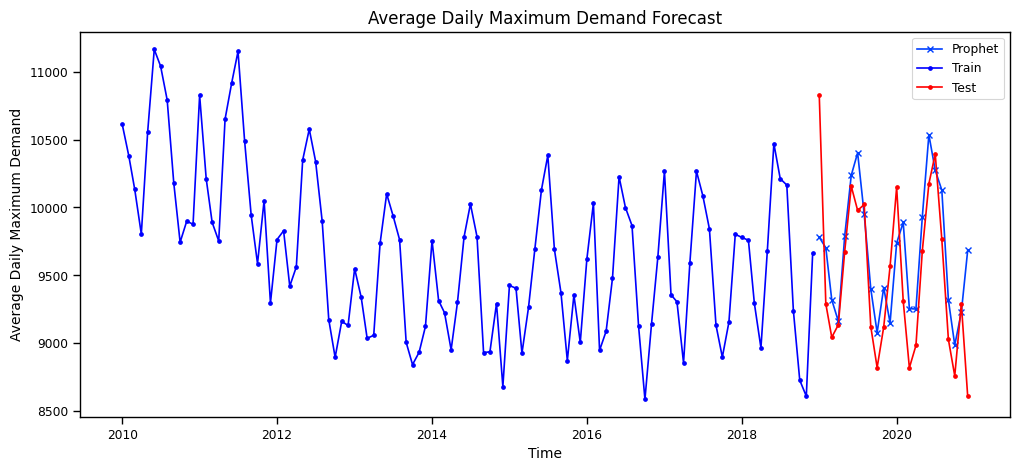

In [113]:
y_pred = prophet_pred['yhat']
models = {
    #'Holt Winter': hw_pred,
    'Prophet': y_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

## Model 4 - Long Short-Term Memory (LSTM) Recurrent Neural Network 

The LSTM model was built using the keras LSTM model. The data is split between the last 24 months of data for test and all the rest is training data.

In [114]:
fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')

In [115]:
# LSTM code
# Test data is last 24 months of given data. 
model_data_new = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
model_data_arr = model_data_new.values
model_data_arr
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_arr)
model_data_arr = scaler.transform(model_data_arr)
# Split training and testing data, testing data is last 24 months
model_data_x = model_data_arr[: , 0:-1]
model_data_y =  model_data_arr[: , -1]
lstm_train_x, lstm_test_x = model_data_x[0:-24 ], model_data_x[-24: ]
lstm_train_y, lstm_test_y  = model_data_y[0:-24 ], model_data_y[-24: ]

# reshape input to be 3D [samples, timesteps, features]
lstm_train_x = lstm_train_x.reshape((lstm_train_x.shape[0], 1, lstm_train_x.shape[1]))
lstm_test_x = lstm_test_x.reshape((lstm_test_x.shape[0], 1, lstm_test_x.shape[1]))
print(lstm_train_x.shape, lstm_train_y.shape, lstm_test_x.shape, lstm_test_y.shape)

(120, 1, 3) (120,) (24, 1, 3) (24,)


Epoch 1/50
1/1 - 3s - loss: 0.1145 - val_loss: 0.1757 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.1133 - val_loss: 0.1739 - 40ms/epoch - 40ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1121 - val_loss: 0.1720 - 42ms/epoch - 42ms/step
Epoch 4/50
1/1 - 0s - loss: 0.1110 - val_loss: 0.1699 - 41ms/epoch - 41ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1099 - val_loss: 0.1677 - 41ms/epoch - 41ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1089 - val_loss: 0.1653 - 43ms/epoch - 43ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1079 - val_loss: 0.1628 - 47ms/epoch - 47ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1069 - val_loss: 0.1603 - 46ms/epoch - 46ms/step
Epoch 9/50
1/1 - 0s - loss: 0.1060 - val_loss: 0.1576 - 46ms/epoch - 46ms/step
Epoch 10/50
1/1 - 0s - loss: 0.1050 - val_loss: 0.1550 - 45ms/epoch - 45ms/step
Epoch 11/50
1/1 - 0s - loss: 0.1040 - val_loss: 0.1524 - 53ms/epoch - 53ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1031 - val_loss: 0.1499 - 47ms/epoch - 47ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1021 - val_loss: 0.147

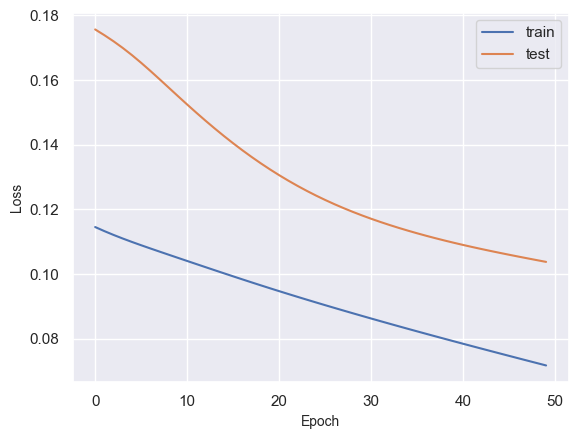

In [159]:
# Run model
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(lstm_train_x, lstm_train_y, epochs=50, batch_size=124, validation_data=(lstm_test_x, lstm_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.show()

1/1 [==============================] - 1s 574ms/step


Text(0, 0.5, 'demand_avg_daily_max (scaled)')

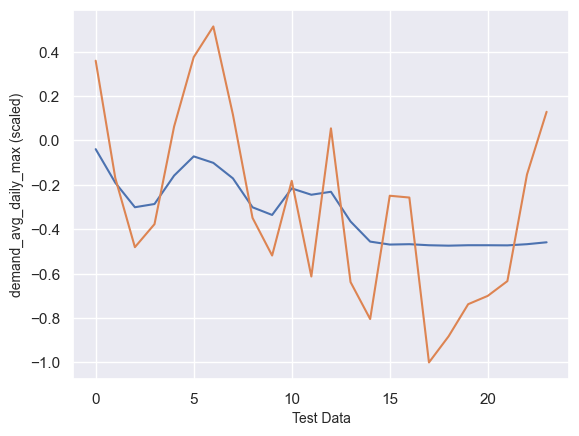

In [160]:
yhat = model.predict(lstm_test_x)
plt.plot(yhat)
plt.plot(lstm_test_y)
plt.xlabel('Test Data', fontsize=10)
plt.ylabel('demand_avg_daily_max (scaled)', fontsize=10)

The test data form the model does notmatch the given data. The model has smoothed the curve and does not take into account the data given. This model should not be used. As expected from the graph, RMSE is very high.

In [118]:
# make a prediction
lstm_test_sx = lstm_test_x.reshape((lstm_test_x.shape[0], lstm_test_x.shape[2]))
# invert scaling for forecast
inv_xyhat = concatenate((lstm_test_sx, yhat), axis=1)
inv_yyhat = scaler.inverse_transform(inv_xyhat)
inv_yhat = inv_yyhat[:,3]
# invert scaling for actual
lstm_test_sy = lstm_test_y.reshape((len(lstm_test_y), 1))
inv_sy = concatenate((lstm_test_sy, lstm_test_sy), axis=1)
inv_ty = concatenate((inv_sy, inv_sy), axis=1)
inv_wy = scaler.inverse_transform(inv_ty)
inv_y = inv_wy[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 615.979


## **Alternative Approaches to Time Series Models**

### Create subsets of features and response variables for subsequent models

In [119]:
# Set python variables
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Read multi-variable dataset into pandas dataframe
df_model_data = read_data(f'{fpath}\{fname_model_data}')

# Prepare dataset into 'features' and 'response'
df_features, df_response, df_model_reduced = prep_data(df_model_data)

# Prepare features and response into nd_arrays
features = df_features.to_numpy()
response = df_response.to_numpy()

## Model 5 - Linear Regression 

#### Set python variables

In [120]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2010 to 2020
start_mth = datetime.datetime(2010, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read multi-variable dataset into pandas dataframe 

In [121]:
df_model_data = read_data(f'{fpath}\{fname_model_data}')

# Convert date column to datetime datatype
df_model_data['date'] = pd.to_datetime(df_model_data['date'])

# Filter records within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

#### Prepare data for Linear Regression

In [122]:
# Prepare dataset into 'features' and 'response'
df_features, df_response, df_model_reduced = prep_data(df_model_data)

# Prepare features and response into nd_arrays
features = df_features.to_numpy()
response = df_response.to_numpy()

#### Create a Correlation Matrix of the variables  

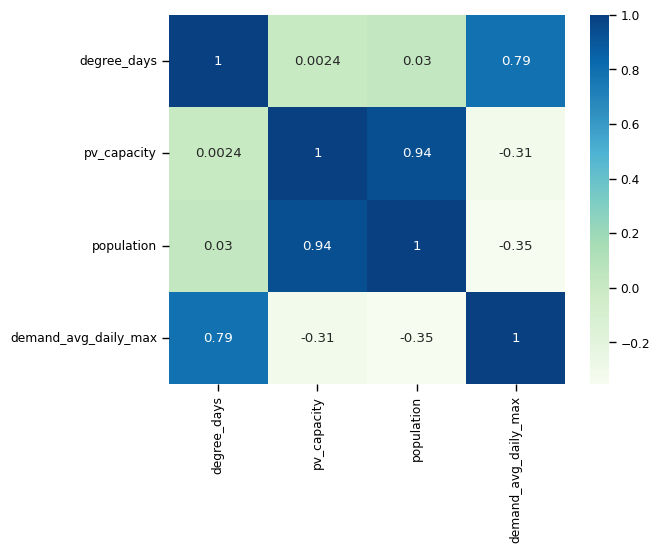

In [123]:
# Create directory for saving figure files
figure_dir = "fig\\linear_model\\"
mkdir_p(figure_dir)

# Set figure file name
figure_file_name = 'corr_map_heatmap.png'

# Plot a Seaborn heatmap of the correlation matrix from the abalone dataframe
sns.heatmap(df_model_reduced.corr(), cmap="GnBu", annot=True)
plt.savefig(figure_dir + figure_file_name)

#### Plot a scatter plot of two most correlated features with Average Daily Maximum Demand

In [124]:
# List features by highest absolute value of correlation with demand_avg_daily_max
absolute_corr_with_demand = df_model_reduced.corr()['demand_avg_daily_max'].apply(abs).sort_values(ascending=False)
print(absolute_corr_with_demand)

demand_avg_daily_max    1.000000
degree_days             0.787922
population              0.353260
pv_capacity             0.307144
Name: demand_avg_daily_max, dtype: float64


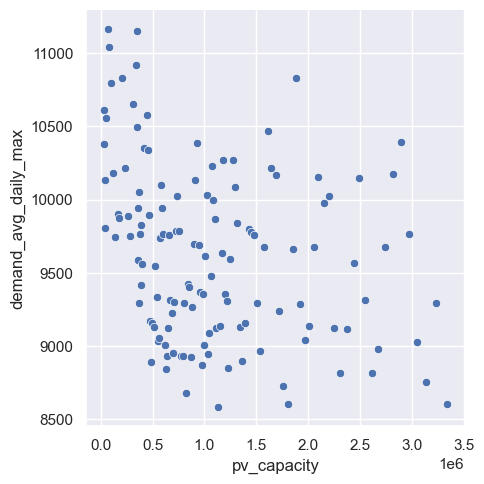

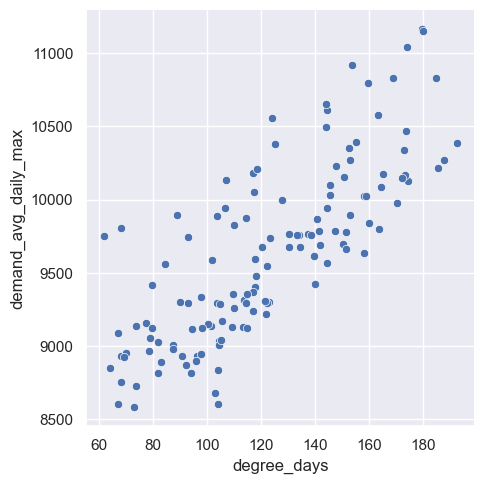

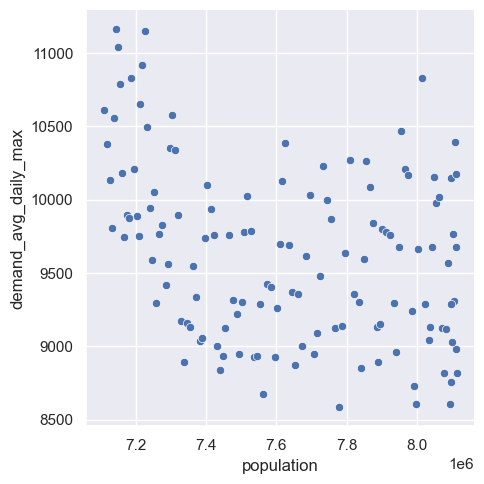

In [125]:
# Create directory for saving figure files
figure_dir = "fig\\linear_model\\"
mkdir_p(figure_dir)

# Set figure file name
figure_file_name = 'scatter_pv_capacity_demand.png'

# Create scatter plots of shell_w and diameter with rings, differentiating the 'sex' by colour
sns.set()
sns.relplot( 
    data = df_model_reduced, 
    kind = 'scatter', 
    x = 'pv_capacity',
    y = 'demand_avg_daily_max',
    #hue = 'sex' # Specify colours for the points
)
plt.savefig(figure_dir + figure_file_name)

# Set figure file name
figure_file_name = 'scatter_degree_days_demand.png'

sns.relplot( 
    data = df_model_reduced, 
    kind = 'scatter', 
    x = 'degree_days',
    y = 'demand_avg_daily_max',
    #hue = 'sex' # Specify colours for the points
)
plt.savefig(figure_dir + figure_file_name)

# Set figure file name
figure_file_name = 'scatter_population_demand.png'

sns.relplot( 
    data = df_model_reduced, 
    kind = 'scatter', 
    x = 'population',
    y = 'demand_avg_daily_max',
    #hue = 'sex' # Specify colours for the points
)
plt.savefig(figure_dir + figure_file_name)

#### Create histograms of the two most correlated predictors with Average Daily Maximum Demand

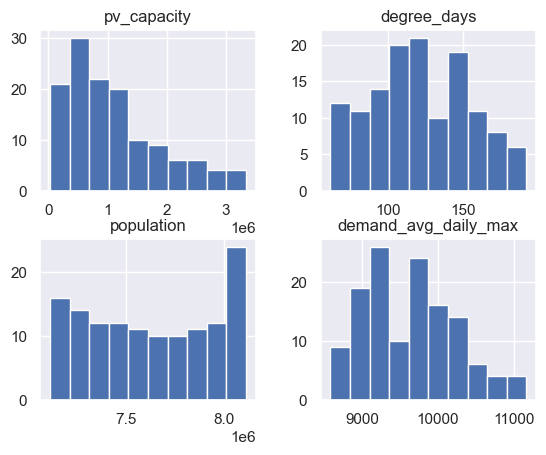

In [126]:
# Create directory for saving figure files
figure_dir = "fig\\linear_model\\"
mkdir_p(figure_dir)

# Set figure file name
figure_file_name = 'hist_pv_capacity_degree_days_pop_demand.png'

#Create histograms for degree_days, pv_capacity, population and demand_avg_daily_max
cols = ['pv_capacity','degree_days', 'population', 'demand_avg_daily_max']
df_model_reduced.hist(column=cols)
plt.savefig(figure_dir + figure_file_name)

#### Run 30 Linear Regression experiments using all features without normalisation

Mean RMSE of Test dataset without normalisation:  289.24873510297317
STD RMSE of Test dataset without normalisation:  40.50803032655083
Mean RMSE of Train dataset without normalisation:  279.3237256822309
STD RMSE of Train dataset without normalisation:  10.279186080148591
Mean R-squared of Test dataset without normalisation:  0.7582796836570626
STD R-squared of Test dataset without normalisation:  0.07166105688679239
Mean R-squared of Train dataset without normalisation:  0.7772931477507529
STD R-squared of Train dataset without normalisation:  0.017381821701606594
Mean MAPE of Test dataset without normalisation:  2.4723240859895297
STD MAPE of Test dataset without normalisation:  0.3537554441322411
Mean MAPE of Train dataset without normalisation:  2.325169639620426
STD MAPE of Train dataset without normalisation:  0.0953548028561823


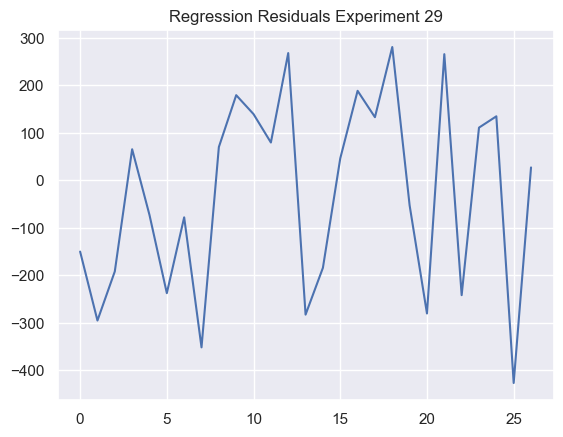

In [127]:
# Prepare features and response
features = df_features.to_numpy()
response = df_response.to_numpy()

# WITHOUT NORMALISATION

# Create directory for saving figure files
figure_dir = "fig\\linear_model\\all_features_without_norm\\"
mkdir_p(figure_dir)

# Set maximum number of experiments, train split ratio, normalisation flag
max_experiments = 30
train_split = 0.8
norm_flag = False

# Execute Linear Regression experiment
_, mean_rmse_test, std_rmse_test, \
    _, mean_rsq_test, std_rsq_test, \
    _, mean_mape_test, std_mape_test, \
    _, mean_rmse_train, std_rmse_train, \
    _, mean_rsq_train, std_rsq_train, \
    _, mean_mape_train, std_mape_train, _ = run_experiments(
                                                        features, 
                                                        response, 
                                                        norm_flag, 
                                                        max_experiments, 
                                                        train_split,
                                                        figure_dir )

print('Mean RMSE of Test dataset without normalisation: ', mean_rmse_test)
print('STD RMSE of Test dataset without normalisation: ', std_rmse_test)
print('Mean RMSE of Train dataset without normalisation: ', mean_rmse_train)
print('STD RMSE of Train dataset without normalisation: ', std_rmse_train)
print('Mean R-squared of Test dataset without normalisation: ', mean_rsq_test)
print('STD R-squared of Test dataset without normalisation: ', std_rsq_test)
print('Mean R-squared of Train dataset without normalisation: ', mean_rsq_train)
print('STD R-squared of Train dataset without normalisation: ', std_rsq_train)
print('Mean MAPE of Test dataset without normalisation: ', mean_mape_test)
print('STD MAPE of Test dataset without normalisation: ', std_mape_test)
print('Mean MAPE of Train dataset without normalisation: ', mean_mape_train)
print('STD MAPE of Train dataset without normalisation: ', std_mape_train)

#### Run 30 Linear Regression experiments using all features with normalisation

Mean RMSE of Test dataset with normalisation:  270.2665296424299
STD RMSE of Test dataset with normalisation:  48.15847026899776
Mean RMSE of Train dataset with normalisation:  262.43597916441087
STD RMSE of Train dataset with normalisation:  12.020399409697646
Mean R-squared of Test dataset with normalisation:  0.7872146923951794
STD R-squared of Test dataset with normalisation:  0.07405250036095533
Mean R-squared of Train dataset with normalisation:  0.8032863138636697
STD R-squared of Train dataset with normalisation:  0.01851402079664718
Mean MAPE of Test dataset without normalisation:  2.2173080661896596
STD MAPE of Test dataset without normalisation:  0.36253626640019515
Mean MAPE of Train dataset without normalisation:  2.1158963536997626
STD MAPE of Train dataset without normalisation:  0.10271810672969559


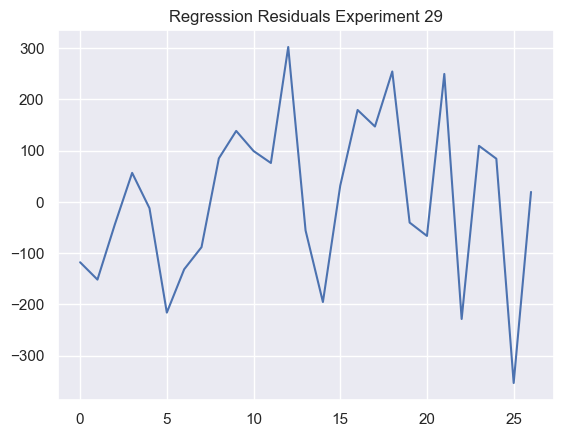

In [128]:
# WITH NORMALISATION

# Create directory for saving figure files
figure_dir = "fig\\linear_model\\all_features_with_norm\\"
mkdir_p(figure_dir)

# Set maximum number of experiments, train split ratio, normalisation flag
max_experiments = 30
train_split = 0.8
norm_flag = True

# Execute Linear Regression experiment
_, mean_rmse_test, std_rmse_test, \
    _, mean_rsq_test, std_rsq_test, \
    _, mean_mape_test, std_mape_test, \
    _, mean_rmse_train, std_rmse_train, \
    _, mean_rsq_train, std_rsq_train, \
    _, mean_mape_train, std_mape_train, _ = run_experiments(
                                                        features, 
                                                        response, 
                                                        norm_flag, 
                                                        max_experiments, 
                                                        train_split,
                                                        figure_dir )

print('Mean RMSE of Test dataset with normalisation: ', mean_rmse_test)
print('STD RMSE of Test dataset with normalisation: ', std_rmse_test)
print('Mean RMSE of Train dataset with normalisation: ', mean_rmse_train)
print('STD RMSE of Train dataset with normalisation: ', std_rmse_train)
print('Mean R-squared of Test dataset with normalisation: ', mean_rsq_test)
print('STD R-squared of Test dataset with normalisation: ', std_rsq_test)
print('Mean R-squared of Train dataset with normalisation: ', mean_rsq_train)
print('STD R-squared of Train dataset with normalisation: ', std_rsq_train)
print('Mean MAPE of Test dataset without normalisation: ', mean_mape_test)
print('STD MAPE of Test dataset without normalisation: ', std_mape_test)
print('Mean MAPE of Train dataset without normalisation: ', mean_mape_train)
print('STD MAPE of Train dataset without normalisation: ', std_mape_train)

#### Run 30 Linear Regression experiments using 2 Features Without Normalisation

Mean RMSE of Test dataset without normalisation:  295.2863708414798
STD RMSE of Test dataset without normalisation:  30.384702236980768
Mean RMSE of Train dataset without normalisation:  290.3270046539359
STD RMSE of Train dataset without normalisation:  7.950394209078473
Mean R-squared of Test dataset without normalisation:  0.7493017925978214
STD R-squared of Test dataset without normalisation:  0.0654741307301992
Mean R-squared of Train dataset without normalisation:  0.7594832626311531
STD R-squared of Train dataset without normalisation:  0.015420983499784994
Mean MAPE of Test dataset without normalisation:  2.575305447899276
STD MAPE of Test dataset without normalisation:  0.2903106773227404
Mean MAPE of Train dataset without normalisation:  2.49566082048087
STD MAPE of Train dataset without normalisation:  0.07641832392415047


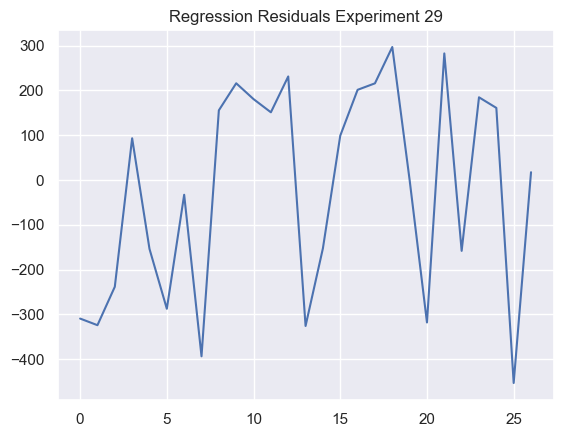

In [129]:
# Create subset of features
df_features_subset = df_features[['degree_days','population']]

# Prepare features and response
features = df_features_subset.to_numpy()
response = df_response.to_numpy()

# WITHOUT NORMALISATION

# Create directory for saving figure files
figure_dir = "fig\\linear_model\\2_features_without_norm\\"
mkdir_p(figure_dir)

# Set maximum number of experiments, train split ratio, normalisation flag
max_experiments = 30
train_split = 0.8
norm_flag = False

# Execute Linear Regression experiment
_, mean_rmse_test, std_rmse_test, \
    _, mean_rsq_test, std_rsq_test, \
    _, mean_mape_test, std_mape_test, \
    _, mean_rmse_train, std_rmse_train, \
    _, mean_rsq_train, std_rsq_train, \
    _, mean_mape_train, std_mape_train, _ = run_experiments(
                                                        features, 
                                                        response, 
                                                        norm_flag, 
                                                        max_experiments, 
                                                        train_split,
                                                        figure_dir )

print('Mean RMSE of Test dataset without normalisation: ', mean_rmse_test)
print('STD RMSE of Test dataset without normalisation: ', std_rmse_test)
print('Mean RMSE of Train dataset without normalisation: ', mean_rmse_train)
print('STD RMSE of Train dataset without normalisation: ', std_rmse_train)
print('Mean R-squared of Test dataset without normalisation: ', mean_rsq_test)
print('STD R-squared of Test dataset without normalisation: ', std_rsq_test)
print('Mean R-squared of Train dataset without normalisation: ', mean_rsq_train)
print('STD R-squared of Train dataset without normalisation: ', std_rsq_train)
print('Mean MAPE of Test dataset without normalisation: ', mean_mape_test)
print('STD MAPE of Test dataset without normalisation: ', std_mape_test)
print('Mean MAPE of Train dataset without normalisation: ', mean_mape_train)
print('STD MAPE of Train dataset without normalisation: ', std_mape_train)

#### Run 30 Linear Regression experiments using 2 Features With Normalisation

Mean RMSE of Test dataset with normalisation:  327.82252752291913
STD RMSE of Test dataset with normalisation:  35.212181418877066
Mean RMSE of Train dataset with normalisation:  317.73396920586737
STD RMSE of Train dataset with normalisation:  8.969333602217928
Mean R-squared of Test dataset with normalisation:  0.6903944252849994
STD R-squared of Test dataset with normalisation:  0.08454271393500103
Mean R-squared of Train dataset with normalisation:  0.7118680384762992
STD R-squared of Train dataset with normalisation:  0.019706240846065884
Mean MAPE of Test dataset without normalisation:  2.7413418273522265
STD MAPE of Test dataset without normalisation:  0.3119395477652819
Mean MAPE of Train dataset without normalisation:  2.625439491178507
STD MAPE of Train dataset without normalisation:  0.09453670545987126


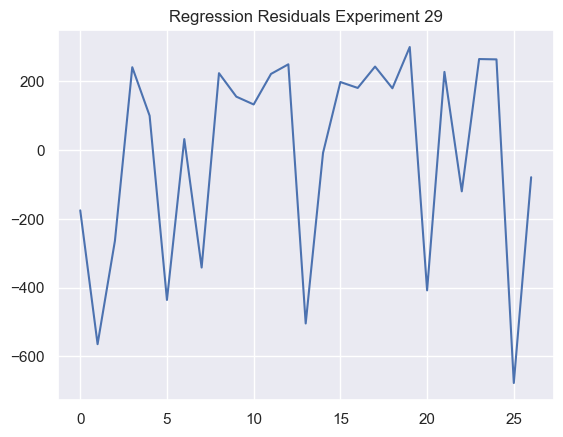

In [130]:
# WITH NORMALISATION

# Create directory for saving figure files
figure_dir = "fig\\linear_model\\2_features_with_norm\\"
mkdir_p(figure_dir)

# Set maximum number of experiments, train split ratio, normalisation flag
max_experiments = 30
train_split = 0.8
norm_flag = True

# Execute Linear Regression experiment
_, mean_rmse_test, std_rmse_test, \
    _, mean_rsq_test, std_rsq_test, \
    _, mean_mape_test, std_mape_test, \
    _, mean_rmse_train, std_rmse_train, \
    _, mean_rsq_train, std_rsq_train, \
    _, mean_mape_train, std_mape_train, _ = run_experiments(
                                                        features, 
                                                        response, 
                                                        norm_flag, 
                                                        max_experiments, 
                                                        train_split,
                                                        figure_dir )

print('Mean RMSE of Test dataset with normalisation: ', mean_rmse_test)
print('STD RMSE of Test dataset with normalisation: ', std_rmse_test)
print('Mean RMSE of Train dataset with normalisation: ', mean_rmse_train)
print('STD RMSE of Train dataset with normalisation: ', std_rmse_train)
print('Mean R-squared of Test dataset with normalisation: ', mean_rsq_test)
print('STD R-squared of Test dataset with normalisation: ', std_rsq_test)
print('Mean R-squared of Train dataset with normalisation: ', mean_rsq_train)
print('STD R-squared of Train dataset with normalisation: ', std_rsq_train)
print('Mean MAPE of Test dataset without normalisation: ', mean_mape_test)
print('STD MAPE of Test dataset without normalisation: ', std_mape_test)
print('Mean MAPE of Train dataset without normalisation: ', mean_mape_train)
print('STD MAPE of Train dataset without normalisation: ', std_mape_train)

#### Obtain Learning Curve for one experiment

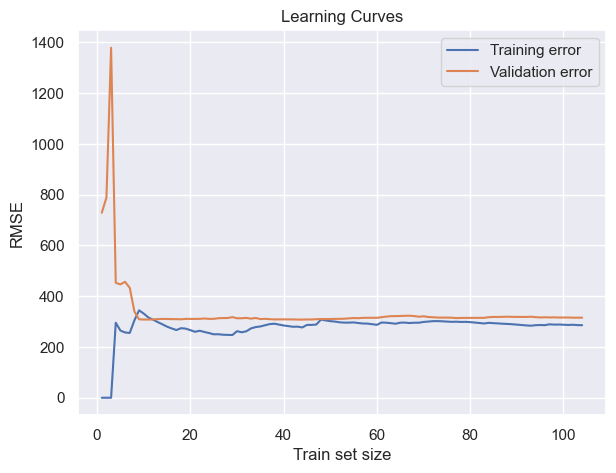

In [161]:
# Scale features
transformer = MinMaxScaler().fit(features)  # fit does nothing.
features_scaled = transformer.transform(features)

# Obtain an 80/20 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, response, test_size = 0.2, random_state = 1)

# Plot the learning curve
plot_learning_curve(X_train, X_test, y_train, y_test)

#### Create Test/Train data for subsequent models

In [135]:
peakDemand_w_DD = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]

In [136]:
peakDemand_w_DD.tail()

degree_days  pv_capacity  population  demand_avg_daily_max
139     9.312500  3954209.744     8091356           8410.176667
140     8.997917  4033918.477     8088503           8469.680000
141     9.254167  4112353.036     8092743           8575.093333
142    12.354167  4192992.282     8096983           9336.970000
143    17.056250  4291459.770     8101223           9784.833333

In [137]:
X1 = peakDemand_w_DD.iloc[:,[0,1,2]].values
transformer = MinMaxScaler().fit(X1)  # fit does nothing.
X1 = transformer.transform(X1)
y1 = peakDemand_w_DD.iloc[:, 3].values

In [138]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 1)

## Model 6 (Linear Regression with Regularization), Model 7 (Random Forest) & Model 8 (Gradient Boosting)

In [139]:
pipelines={
'rf':make_pipeline(RandomForestRegressor(random_state=1)),
'gb':make_pipeline(GradientBoostingRegressor(random_state=1)),
'ridge':make_pipeline(Ridge(random_state=1)),
'lasso':make_pipeline(Lasso(random_state=1)),
'enet':make_pipeline(ElasticNet(random_state=1)),
   
}

In [140]:
hyperparagrid={

'rf':{
'randomforestregressor__min_samples_split':[2,4,6],
'randomforestregressor__min_samples_leaf':[1,2,3]
},
    
'gb':{
    'gradientboostingregressor__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]
},

'ridge':{
    'ridge__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]
},
'lasso':{
    'lasso__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]
},
'enet':{
   'elasticnet__alpha':[0.001,0.005,0.01,0.05,0.1,0.5,0.99]
}

}

In [141]:
fit_models={}
for algo,pipeline in pipelines.items():
    model=GridSearchCV(pipeline,hyperparagrid[algo],cv=10,n_jobs=-1)
    try:
        print('Start training for {}'.format(algo))
        model.fit(X1_train,y1_train)
        fit_models[algo]=model
        #print('{} Train scores-R2:{} Train RMSE:{}'.format(algo,r2_score(y1_train,model), np.sqrt(mean_squared_error(y1_train,model))))
    except NotFittedError as e:
        print(repr(e))

Start training for rf


Start training for gb
Start training for ridge
Start training for lasso
Start training for enet


In [142]:
for algo,model in fit_models.items():
    ymd=model.predict(X1_test)
    print('{} scores-R2:{} RMSE:{} MAPE:{}'.format(algo,r2_score(y1_test,ymd), np.sqrt(mean_squared_error(y1_test,ymd)), mean_absolute_percentage_error(y1_test, ymd)*100))

rf scores-R2:0.8753734434904149 RMSE:246.43890608573477 MAPE:2.0413934417325015
gb scores-R2:0.8734939874439132 RMSE:248.29018848131616 MAPE:2.097260512133142
ridge scores-R2:0.8061318255372333 RMSE:307.3669977080993 MAPE:2.6211908567811784
lasso scores-R2:0.8101504057806013 RMSE:304.1647006179112 MAPE:2.596196010819959
enet scores-R2:0.8098441562838888 RMSE:304.40992829819413 MAPE:2.598199227004693


In [143]:
best_model=fit_models['rf']

In [144]:
best_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [2, 4, 6]})

In [145]:
best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [2, 4, 6]})>

## Model 9 - Stacking Ensemble

In [146]:
# Linear Ensemble code
X = peakDemand_w_DD.iloc[:,[0,1,2]].values
transformer = MinMaxScaler().fit(X)  # fit does nothing.
X = transformer.transform(X)
y = peakDemand_w_DD.iloc[:, 3].values

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [148]:
# get the models to evaluate
models = get_models()

In [149]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>knn -245.989 (58.313)
>cart -252.108 (56.727)


>rf -212.625 (57.584)
>gb -208.101 (65.456)
>svm -524.214 (80.028)
>stacking -213.696 (62.949)


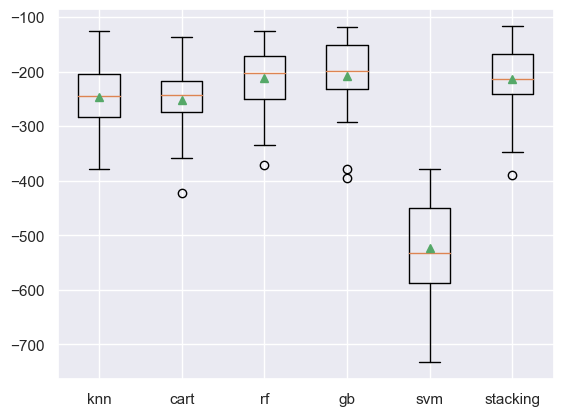

In [150]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

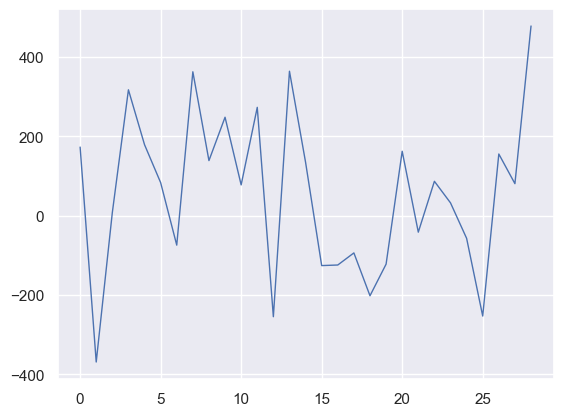

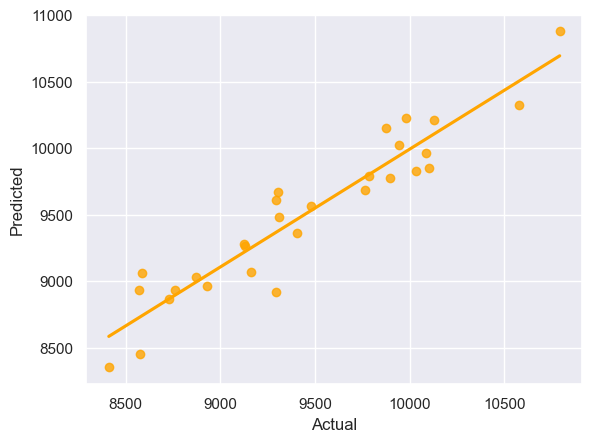

RMSE: 210.0784031987869
MAPE: 1.87389969247812 %
R-Squared: 0.8855876382444513


In [151]:
# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('rf', RandomForestRegressor()))
level0.append(('gb', GradientBoostingRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X_train, y_train)
# make a prediction for one example
yhat = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, yhat))
mape = mean_absolute_percentage_error(y_test, yhat)*100
rsquared = r2_score(y_test, yhat)
residuals = yhat - y_test
plt.plot(residuals, linewidth=1)
plt.savefig('scikit_linear.png')
plt.show()
sns.regplot(x=y_test,y=yhat,ci=None,color ='orange');
plt.xlabel('Actual');
plt.ylabel('Predicted');
plt.savefig('regression_plot_2 features.png')
plt.show()
print('RMSE:', rmse)
print('MAPE:', str(mape) + str(' %'))
print('R-Squared:', rsquared)


## Model 10 - Fast Forward Neural Network 

The neural network chiosedn is a 4 layer FNN. The 3 hidden layers contain 60 nodes. This model showed a slight imporvement to 4 hidden layers so this model was chosen. RMSE is 327 for thios model and the graph is much closer to the given data.


In [152]:
# FF-NN code

fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')
model_data = model_data.drop(model_data[model_data['year'] == 2021].index)

In [153]:
model_data_new = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_new)
model_data_new = scaler.transform(model_data_new)
# Split training and testing data, testing data is last 24 months
model_data_new.shape
nn_train_x, nn_test_x, nn_train_y, nn_test_y  = train_test_split(model_data_new[ : , 0 : -1], model_data_new[: , -1] , test_size=0.4)

# reshape input to be 3D [samples, timesteps, features]

print(nn_train_x.shape, nn_train_y.shape, nn_test_x.shape, nn_test_y.shape)

(79, 3) (79,) (53, 3) (53,)


In [154]:
model_data.tail()

year  month        date  temp_mean  temp_min  temp_max   
127  2020      8  2020-08-01  14.613374       2.2      27.8  \
128  2020      9  2020-09-01  16.460153       4.9      30.5   
129  2020     10  2020-10-01  17.598051       7.0      30.2   
130  2020     11  2020-11-01  20.184861       6.5      40.4   
131  2020     12  2020-12-01  19.403831       5.2      32.3   

     temp_avg_daily_min  temp_avg_daily_max  degree_days  demand_mean   
127            9.093548           20.074194   130.397917  7827.362594  \
128           11.330000           21.723333    81.650543  7326.909750   
129           13.467742           21.980645    68.068750  7340.289409   
130           14.886667           25.863333   114.450000  7584.268118   
131           15.470968           24.016129   104.077083  7300.258421   

     demand_max  demand_avg_daily_max  total_consumption  pv_capacity   
127    11500.53           9764.800000        5823557.770  2969007.614  \
128    11721.16           9027.053000        5268048.110  3054829.298   
129    11920.34           8757.940323        5461175.320  3137388.115   
130    12401.82           9291.636333        5460673.045  3234844.871   
131    10863.32           8608.121290        5431392.265  3340420.498   

     population           gsp  
127     8102807  56109.666667  
128     8098905  56109.666667  
129     8097370  56109.666667  
130     8095835  56109.666667  
131     8094300  56109.666667

Epoch 1/50


1/1 - 2s - loss: 0.5719 - val_loss: 0.4047 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.4162 - val_loss: 0.2749 - 59ms/epoch - 59ms/step
Epoch 3/50
1/1 - 0s - loss: 0.2980 - val_loss: 0.1816 - 55ms/epoch - 55ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2120 - val_loss: 0.1188 - 52ms/epoch - 52ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1524 - val_loss: 0.0810 - 42ms/epoch - 42ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1140 - val_loss: 0.0629 - 48ms/epoch - 48ms/step
Epoch 7/50
1/1 - 0s - loss: 0.0915 - val_loss: 0.0593 - 48ms/epoch - 48ms/step
Epoch 8/50
1/1 - 0s - loss: 0.0804 - val_loss: 0.0653 - 54ms/epoch - 54ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0767 - val_loss: 0.0765 - 57ms/epoch - 57ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0775 - val_loss: 0.0895 - 53ms/epoch - 53ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0806 - val_loss: 0.1016 - 59ms/epoch - 59ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0848 - val_loss: 0.1111 - 53ms/epoch - 53ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0892 - val_loss: 0.1166 - 57ms/ep

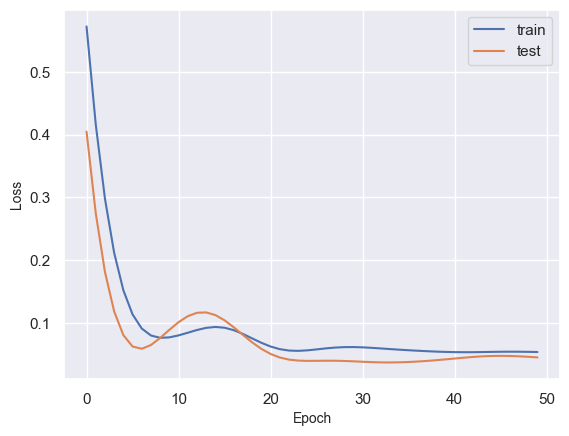

In [155]:
# Run model
# design network
model = Sequential()
model.add(Dense(60))
model.add(Dense(60))
model.add(Dense(60))
#model.add(Dense(60))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(nn_train_x, nn_train_y, epochs=50, batch_size=124, validation_data=(nn_test_x, nn_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step


Text(0, 0.5, 'demand_avg_daily_max (scaled)')

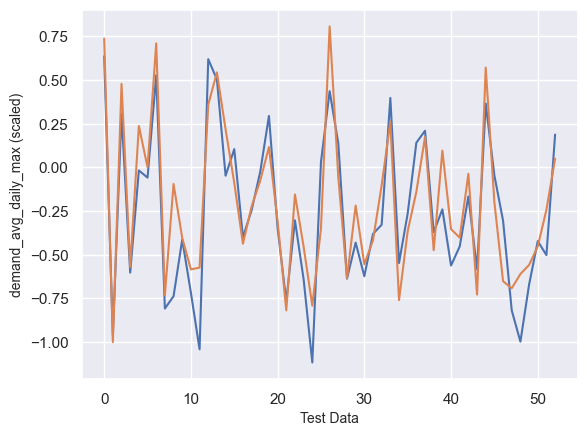

In [156]:
# make a prediction
yhat = model.predict(nn_test_x)
yhat
plt.plot(yhat)
plt.plot(nn_test_y)
plt.xlabel('Test Data', fontsize=10)
plt.ylabel('demand_avg_daily_max (scaled)', fontsize=10)

In [157]:
# make a prediction
# invert scaling for forecast
inv_yhat = concatenate((nn_test_x, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
nn_test_y = nn_test_y.reshape((len(nn_test_y), 1))
inv_y = concatenate((nn_test_x, nn_test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 275.591
